In [1]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
# import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [544]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path, sample=''):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
            
    affix = '_' + sample+ str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)

    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    print(n_combine)
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_elais, radial_xmmlss, radial_deep])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))

def combine_deep_fields(fields, csfq, ssfq, masscut_low, masscut_high, z, path, sample='',bin_number=14):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
    affix = '_' + sample+ str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    
    radial_combine = np.zeros(bin_number)
    radial_err_combine =  np.zeros(bin_number)
    n_fields = []
    for field in fields:
        data_field = np.genfromtxt(path+'count'+field+affix)
        split_index = int(((len(data_field)-1)/2)+1)
            
        n_field = data_field[0]
        radial_field = data_field[1:split_index]
        radial_field_err = data_field[split_index:]
        
        n_fields.append(n_field)
        radial_combine = np.vstack([radial_combine, radial_field])
        radial_err_combine = np.vstack([radial_err_combine, radial_field_err])
        
    # remove the no.zeros line
    radial_combine = radial_combine[1:,:]
    radial_err_combine = radial_err_combine[1:,:]
    
    n_tot = sum(n_fields)   
    radial = np.average(radial_combine, axis=0, weights=n_fields)
    radial_err = np.sqrt(sum(radial_err_combine**2*n_field**2))/sum(n_fields)
    return (radial, radial_err, n_tot)

def load_deep(field_name,csfq, ssfq, masscut_low, masscut_high, z, path, sample=''):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
            
    affix = '_' + sample + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    field_deep = np.genfromtxt(path+'count'+field_name+affix)
    n_field = int(field_deep[0])
    
    split_index = int(((len(field_deep)-1)/2)+1)
    radial_field = field_deep[1:split_index]
    radial_field_err = field_deep[split_index:]
    return (radial_field, radial_field_err, n_field)

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, 2.845, num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)

## NFW model

In [4]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Sersic + NFW model

In [123]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start):
    xdata = xdata[start-1:-1]
    ydata = ydata[start-1:-1]
    ydata_err = ydata_err[start-1:-1]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0],[10000, 2e-2, 2e-2, 300, 40]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def fit_nfw_sersic_fix_n(xdata, ydata, ydata_err, start,fix_n=0.26):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 0.26]
                          ,bounds=([0, 0, 0 ,0 ,fix_n-0.001],[10000, 2e-2, 2e-2, 300, fix_n+0.001]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

In [6]:
def aic(chi2,n,k):
    return chi2 + 2*k + k*(k+1)/(n-k-1)

## Power Law Model

In [7]:
def power_law(r, I, a):
    return I*r**a

from scipy.optimize import curve_fit
def fit_power(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(power_law,xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    res = ydata - power_law(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Total Satellite Sample

In [8]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

def red_frac_err_new(q, All, q_err, all_err):
    return np.sqrt( q_err**2*(1/All)**2 + all_err**2*(q/All**2)**2)
# move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

fitting NFW+Sersic
dof: 6
--------all---------
[4.316e+02 2.031e-05 1.052e-04 3.595e+01 3.013e-01] [6.869e+01 3.138e-06 9.841e-06 1.587e+00 7.890e-02] Chi2_dof=4.74
[6.006e+02 1.249e-05 9.501e-05 4.011e+01 5.885e-01] [1.703e+02 3.196e-06 9.693e-06 2.410e+00 1.686e-01] Chi2_dof=3.06
[8.246e+02 1.131e-05 5.310e-05 3.775e+01 2.610e-01] [2.809e+02 3.166e-06 1.489e-05 5.805e+00 2.201e-01] Chi2_dof=66.33
['COSMOS_deep', 'ELAIS_deep', 'DEEP_deep', 'XMM-LSS_deep', 'SXDS_uddd']


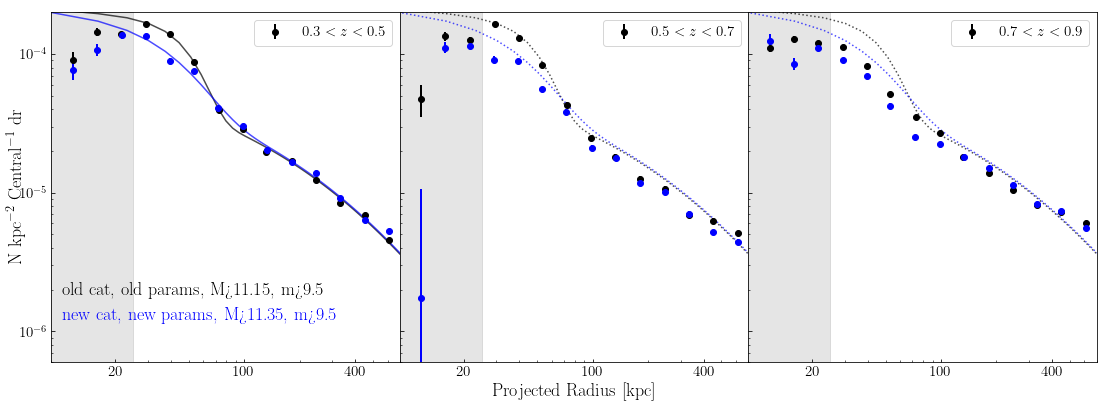

In [631]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
field_names = [ 'COSMOS_deep','ELAIS_deep', 'DEEP_deep','XMM-LSS_deep','SXDS_uddd']
# field_names = ['ELAIS_deep']

#============= primary data ============
csfq = 'all'
path = 'CUT_deep_catalogs/total_sample_0312/' 
sample_name1 = 'old cat, old params, M>11.15, m>9.5'

bin_edges = np.load(path+'bin_centers.npy')
count_radial_4 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.4,path,sample=sample_all)
count_radial_6 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.6,path,sample=sample_all)
count_radial_8 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.8,path,sample=sample_all)


# ============ secondary data ============
csfq = 'all'
path2 = 'CUT_deep_catalogs/total_sample_new_cat_M1135_m95_0316/' 
sample_name2 = 'new cat, new params, M>11.35, m>9.5'

bin_edges2 = np.load(path2+'bin_centers.npy')
count_radial_4_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.4,path2,sample=sample_all)
count_radial_6_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.6,path2,sample=sample_all)
count_radial_8_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.8,path2,sample=sample_all)

#==============plot============
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].errorbar(bin_edges2, count_radial_4_2[0],count_radial_4_2[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges2, count_radial_6_2[0],count_radial_6_2[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges2, count_radial_8_2[0],count_radial_8_2[1],fmt='ob',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#========= fitting =====================
fit_x = np.linspace(2,700,num=100)
start = 4

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)

perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))

popt42,pcov42,chi2_42 = fit_nfw_sersic(bin_edges,count_radial_4_2[0],count_radial_4_2[1], start)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),'b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)
# axs[1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),'k',alpha=0.7)
# axs[2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),'k',alpha=0.7,label='NFW+Sersic fit')

np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print('--------all---------')
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))

# print all,sf,q info on figure
axs[0].annotate(sample_name1,xy=([0.03,0.19]),xycoords='axes fraction',fontsize=18)
axs[0].annotate(sample_name2,xy=([0.03,0.12]),xycoords='axes fraction',fontsize=18,color='b')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
# plt.title(r'Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
print(field_names)
plt.show() 

In [117]:
path.split('/')

['CUT_deep_catalogs', 'total_sample_0226', '']

[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
Q-frac for lm central 0.36
Q-frac for lm central 0.553
Q-frac for lm central 0.348
No. of sats at 0.3<z<0.5  total: 10.0 sf: 6.4 q: 3.6
No. of sats at 0.5<z<0.7  total: 8.4 sf: 4.6 q: 3.8
No. of sats at 0.7<z<0.9  total: 10.1 sf: 6.2 q: 3.7
fitting NFW+Sersic
dof: 6
--------all---------
[3.084e+02 2.609e-05 8.973e-05 3.554e+01 3.651e-01] [5.692e+01 5.242e-06 1.211e-05 2.262e+00 1.377e-01] Chi2_dof=1.1
[2.166e+02 3.552e-05 8.303e-05 1.080e+01 1.667e-01] [3.912e+01 7.581e-06 1.148e-05 2.932e+03 4.874e-02] Chi2_dof=1.05
[2.856e+02 2.686e-05 6.090e-05 2.771e+01 2.610e-01] [5.217e+01 5.422e-06 2.147e-05 3.698e+00 2.607e-01] Chi2_dof=3.76
--------sf---------
[3.788e+02 1.396e-05 6.700e-05 3.677e+01 4.210e-01] [1.005e+02 3.824e-06 1.032e-05 2.815e+00 1.842e-01] Chi2_dof=1

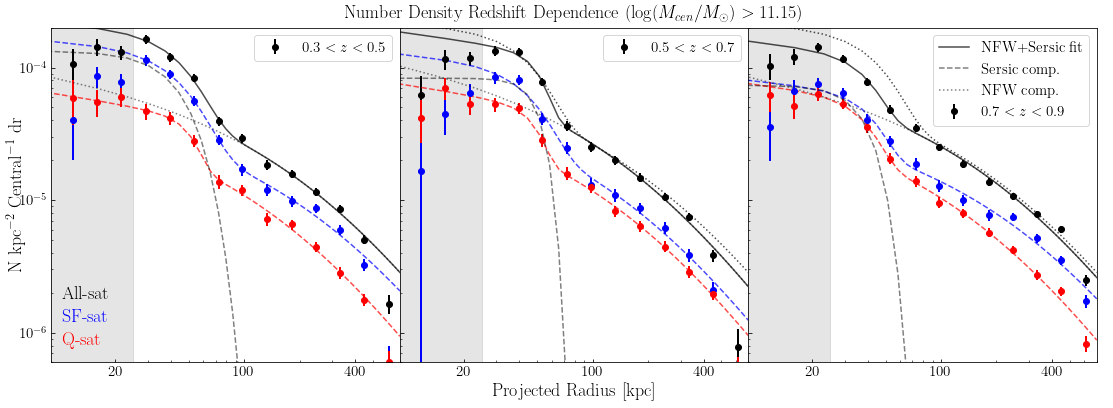

In [206]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/total_sample_0219/' 
# path = 'CUT_deep_catalogs/total_sample_sfprob_3bins/'  #sfprob cut at low=0.4, high=0.8

csfq = 'all'
bin_edges = np.load(path+'bin_centers.npy')
count_radial_4 = combine_deep(csfq,'all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep(csfq,'all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep(csfq,'all','9.5','13.0',0.8,path)
count_radial_4_sf = combine_deep(csfq,'ssf','9.5','13.0',0.4,path)
count_radial_6_sf = combine_deep(csfq,'ssf','9.5','13.0',0.6,path)
count_radial_8_sf = combine_deep(csfq,'ssf','9.5','13.0',0.8,path)
count_radial_4_q = combine_deep(csfq,'sq','9.5','13.0',0.4,path)
count_radial_6_q = combine_deep(csfq,'sq','9.5','13.0',0.6,path)
count_radial_8_q = combine_deep(csfq,'sq','9.5','13.0',0.8,path)

# red fraction
red_frac_4 = count_radial_4_q[0]/count_radial_4[0]
red_frac_6 = count_radial_6_q[0]/count_radial_6[0]
red_frac_8 = count_radial_8_q[0]/count_radial_8[0]
print('Q-frac for lm central',round(np.average(red_frac_4[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_6[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_8[2:],weights=areas[2:]),3))

print('No. of sats at 0.3<z<0.5  total:',round(sum(count_radial_4[0]*areas),1),
      'sf:',round(sum(count_radial_4_sf[0]*areas),1),
      'q:',round(sum(count_radial_4_q[0]*areas),1))

print('No. of sats at 0.5<z<0.7  total:',round(sum(count_radial_6[0]*areas),1),
      'sf:',round(sum(count_radial_6_sf[0]*areas),1),
      'q:',round(sum(count_radial_6_q[0]*areas),1))

print('No. of sats at 0.7<z<0.9  total:',round(sum(count_radial_8[0]*areas),1),
      'sf:',round(sum(count_radial_8_sf[0]*areas),1),
      'q:',round(sum(count_radial_8_q[0]*areas),1))

# plot the distributions

axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].errorbar(bin_edges, count_radial_4_sf[0],count_radial_4_sf[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_sf[0],count_radial_6_sf[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_sf[0],count_radial_8_sf[1],fmt='ob',linewidth=2)

axs[0].errorbar(bin_edges, count_radial_4_q[0],count_radial_4_q[1],fmt='or',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_q[0],count_radial_6_q[1],fmt='or',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_q[0],count_radial_8_q[1],fmt='or',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#=========
fit_x = np.linspace(2,700,num=100)
start = 4
# Power Law Fitting
# print('fitting power law')
# model = 'Power'

# popt4,pcov4,chi2_4 = fit_power(bin_edges,count_radial_4_q[0],count_radial_4_q[1], start)
# popt6,pcov6,chi2_6 = fit_power(bin_edges,count_radial_6_q[0],count_radial_6_q[1], start)
# popt8,pcov8,chi2_8 = fit_power(bin_edges,count_radial_8_q[0],count_radial_8_q[1], start)
# perr4 = np.sqrt(np.diag(pcov4))
# perr6 = np.sqrt(np.diag(pcov6))
# perr8 = np.sqrt(np.diag(pcov8))

# axs[0].plot(fit_x,power_law(fit_x, popt4[0],popt4[1]),'k',alpha=0.7)
# axs[1].plot(fit_x,power_law(fit_x, popt6[0],popt6[1]),'k',alpha=0.7)
# axs[2].plot(fit_x,power_law(fit_x, popt8[0],popt8[1]),'k',alpha=0.7,label='Power law fit')

# NFW Fitting
# print('fitting NFW')
# model = 'NFW'
# popt4,pcov4,chi2_4 = fit_nfw(bin_edges,count_radial_4[0],count_radial_4[1], start)
# popt6,pcov6,chi2_6 = fit_nfw(bin_edges,count_radial_6[0],count_radial_6[1], start)
# popt8,pcov8,chi2_8 = fit_nfw(bin_edges,count_radial_8[0],count_radial_8[1], start)

# axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),'k',alpha=0.5)
# axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),'k',alpha=0.5)
# axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),'k',alpha=0.5,label='NFW fit')

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)

popt4_sf,pcov4_sf,chi2_4_sf = fit_nfw_sersic(bin_edges,count_radial_4_sf[0],count_radial_4_sf[1], start)
popt6_sf,pcov6_sf,chi2_6_sf = fit_nfw_sersic(bin_edges,count_radial_6_sf[0],count_radial_6_sf[1], start)
popt8_sf,pcov8_sf,chi2_8_sf = fit_nfw_sersic_fix_n(bin_edges,count_radial_8_sf[0],count_radial_8_sf[1], start)

popt4_q,pcov4_q,chi2_4_q = fit_nfw_sersic(bin_edges,count_radial_4_q[0],count_radial_4_q[1], start)
popt6_q,pcov6_q,chi2_6_q = fit_nfw_sersic(bin_edges,count_radial_6_q[0],count_radial_6_q[1], start)
popt8_q,pcov8_q,chi2_8_q = fit_nfw_sersic_fix_n(bin_edges,count_radial_8_q[0],count_radial_8_q[1], start)

perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))
perr4_sf = np.sqrt(np.diag(pcov4_sf))
perr6_sf = np.sqrt(np.diag(pcov6_sf))
perr8_sf = np.sqrt(np.diag(pcov8_sf))
perr4_q = np.sqrt(np.diag(pcov4_q))
perr6_q = np.sqrt(np.diag(pcov6_q))
perr8_q = np.sqrt(np.diag(pcov8_q))

# ========== Model Selection =============
# AIC

# aic4 = aic(chi2_4,len(count_radial_4[0])-start+1,len(popt4))
# aic6 = aic(chi2_6,len(count_radial_6[0])-start+1,len(popt4))
# aic8 = aic(chi2_8,len(count_radial_8[0])-start+1,len(popt4))

# print('AIC:',aic4,aic6,aic8)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),'k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),'k',alpha=0.7,label='NFW+Sersic fit')

axs[0].plot(fit_x,nfw_sersic(fit_x, popt4_sf[0],popt4_sf[1],popt4_sf[2],popt4_sf[3],popt4_sf[4]),'--b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6_sf[0],popt6_sf[1],popt6_sf[2],popt6_sf[3],popt6_sf[4]),'--b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8_sf[0],popt8_sf[1],popt8_sf[2],popt8_sf[3],popt8_sf[4]),'--b',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt4_q[0],popt4_q[1],popt4_q[2],popt4_q[3],popt4_q[4]),'--r',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6_q[0],popt6_q[1],popt6_q[2],popt6_q[3],popt6_q[4]),'--r',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8_q[0],popt8_q[1],popt8_q[2],popt8_q[3],popt8_q[4]),'--r',alpha=0.7)

axs[0].plot(fit_x,sersic(fit_x, popt4[2],popt4[3],popt4[4]),'--k',alpha=0.5)
axs[1].plot(fit_x,sersic(fit_x, popt6[2],popt6[3],popt6[4]),'--k',alpha=0.5)
axs[2].plot(fit_x,sersic(fit_x, popt8[2],popt8[3],popt8[4]),'--k',alpha=0.5,label='Sersic comp.')

axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),':k',alpha=0.5)
axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),':k',alpha=0.5)
axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')
 
np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print('--------all---------')
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))
print('--------sf---------')
print(popt4_sf,perr4_sf,'Chi2_dof='+str(round(chi2_4_sf/dof,2)))
print(popt6_sf,perr6_sf,'Chi2_dof='+str(round(chi2_6_sf/dof,2)))
print(popt8_sf,perr8_sf,'Chi2_dof='+str(round(chi2_8_sf/dof,2)))
print('--------q---------')
print(popt4_q,perr4_q,'Chi2_dof='+str(round(chi2_4_q/dof,2)))
print(popt6_q,perr6_q,'Chi2_dof='+str(round(chi2_6_q/dof,2)))
print(popt8_q,perr8_q,'Chi2_dof='+str(round(chi2_8_q/dof,2)))

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.03,0.19]),xycoords='axes fraction',fontsize=18)
axs[0].annotate('SF-sat',xy=([0.03,0.12]),xycoords='axes fraction',fontsize=18,color='b')
axs[0].annotate('Q-sat',xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18,color='r')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.title(r'Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/number_density_zdependence_'+model+'.2bins.png')
plt.show() 

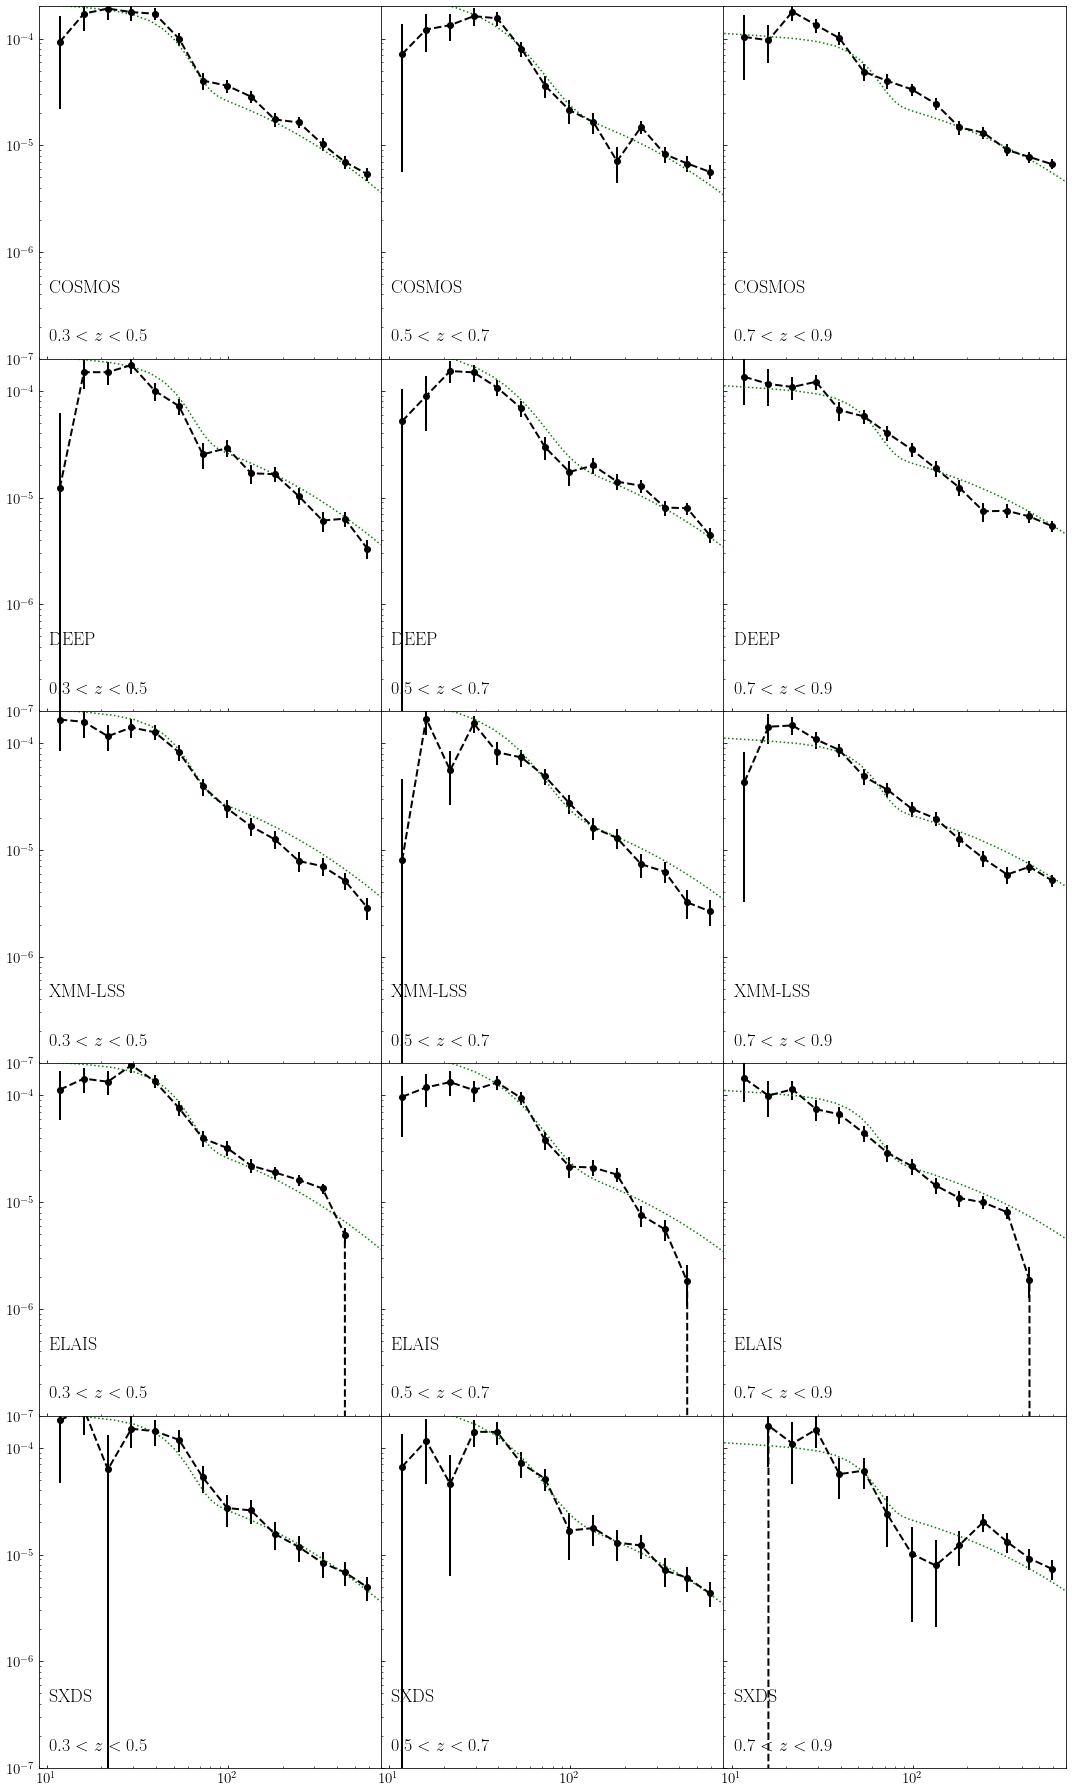

In [586]:
fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize = (15, 25),gridspec_kw={'height_ratios':[1,1,1,1,1]})
path = 'CUT_deep_catalogs/total_sample_0226/'
bin_centers = np.load(path+'bin_centers.npy')
colors=['k']
for i,field in enumerate(['COSMOS_deep','DEEP_deep','XMM-LSS_deep','ELAIS_deep','SXDS_uddd']):
    axs[i][0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':g')
    axs[i][1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),':g')
    axs[i][2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),':g')
    for j,z in enumerate([0.4,0.6,0.8]):
        for k,ssfq in enumerate(['all']):
            affix = '_9.5_all_' + ssfq + '_' + str(round(z,1)) +'.txt'
            radial_full = np.genfromtxt(path+'count'+field+affix)
            split_index = int(((len(radial_full)-1)/2)+1)
            
            radial = radial_full[1:split_index]
            radial_err = radial_full[split_index:]
            axs[i][j].errorbar(bin_centers, radial,radial_err,
                               fmt='o--'+colors[k],linewidth=2)
            axs[i][j].annotate(field.split('_')[0],xy=([0.03,0.19]),xycoords='axes fraction',fontsize=18)
            axs[i][j].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18)
            
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[0][0].set_xlim([9,700])
axs[0][0].set_ylim([1e-7,2e-4])

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/number_density_zdependence_allfields.png')


[269, 115, 302, 272, 258]
[353, 141, 357, 334, 334]


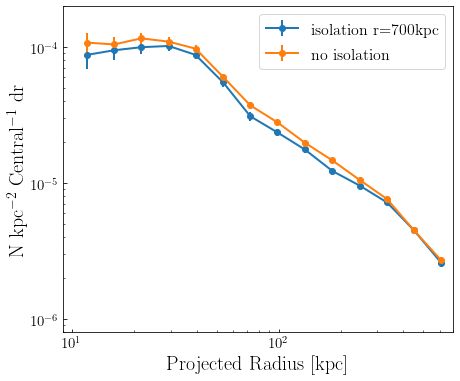

In [16]:
# comparison between different isolation radius
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.4

path1 = 'CUT_deep_catalogs/total_sample/'
path2 = 'CUT_deep_catalogs/without_isolation/'
count_radial1 = combine_deep('all','all','9.5','13.0',z,path=path1)
count_radial2 = combine_deep('all','all','9.5','13.0',z,path=path2)
bin_centers = np.load(path1+'bin_centers.npy')

plt.errorbar(bin_centers, count_radial1[0],count_radial1[1],fmt='o-',linewidth=2,label='isolation r=700kpc')
plt.errorbar(bin_centers, count_radial2[0],count_radial2[1],fmt='o-',linewidth=2,label='no isolation')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([8e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=16)
plt.show(); plt.close()

[250, 108, 328, 224, 293]
[250, 93, 328, 224, 293]


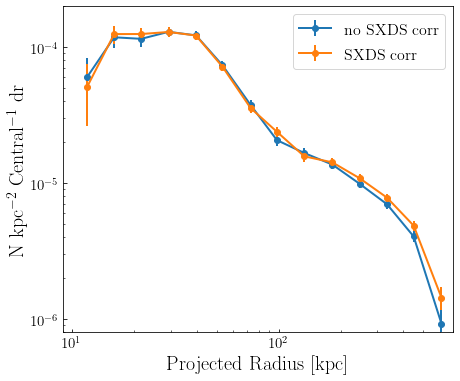

In [17]:
# comparison between different isolation radius
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.6

path1 = 'CUT_deep_catalogs/total_sample_45/'
path2 = 'CUT_deep_catalogs/total_sample_45_SXDS3/'
count_radial1 = combine_deep('all','all','9.5','13.0',z,path=path1)
count_radial2 = combine_deep('all','all','9.5','13.0',z,path=path2)
bin_centers = np.load(path1+'bin_centers.npy')

plt.errorbar(bin_centers, count_radial1[0],count_radial1[1],fmt='o-',linewidth=2,label='no SXDS corr')
plt.errorbar(bin_centers, count_radial2[0],count_radial2[1],fmt='o-',linewidth=2,label='SXDS corr')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([8e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=16)
plt.show(); plt.close()

[526, 91, 605, 433, 416]
[470, 85, 559, 405, 385]


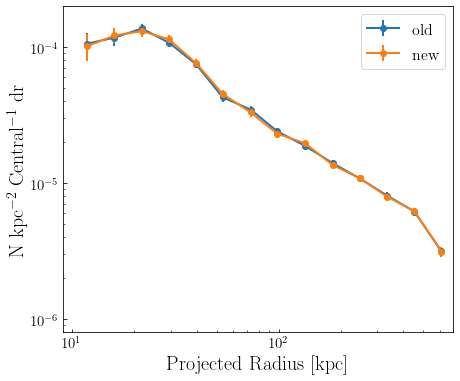

In [18]:
# comparison between different isolation radius
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.8

path1 = 'CUT_deep_catalogs/total_sample_45_SXDS3/'
path2 = 'CUT_deep_catalogs/test_z/'
count_radial1 = combine_deep('all','all','9.5','13.0',z,path=path1)
count_radial2 = combine_deep('all','all','9.5','13.0',z,path=path2)
bin_centers = np.load(path1+'bin_centers.npy')

plt.errorbar(bin_centers, count_radial1[0],count_radial1[1],fmt='o-',linewidth=2,label='old')
plt.errorbar(bin_centers, count_radial2[0],count_radial2[1],fmt='o-',linewidth=2,label='new')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([8e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=16)
plt.show(); plt.close()

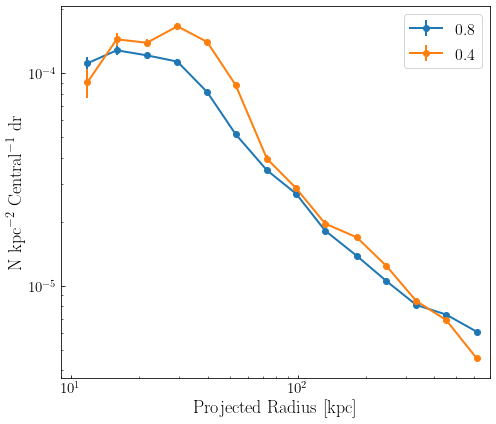

In [592]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.8

path1 = 'CUT_deep_catalogs/total_sample_0312/'
path2 = 'CUT_deep_catalogs/total_sample_0312/'
# count_radial1 = combine_deep('all','all','9.5','13.0',z,path=path1,sample='')
# count_radial2 = combine_deep('all','all','9.5','13.0',z,path=path2,sample='')

field_name1=[ 'COSMOS_deep','ELAIS_deep', 'DEEP_deep','XMM-LSS_deep','SXDS_uddd']
field_name2=[ 'COSMOS_deep','ELAIS_deep', 'DEEP_deep','XMM-LSS_deep','SXDS_uddd']
count_radial1 = combine_deep_fields(field_name1,'all','all','9.5','13.0',0.8,path1,sample='')
count_radial2 = combine_deep_fields(field_name2,'all','all','9.5','13.0',0.4,path2,sample='')

bin_centers = np.load(path1+'bin_centers.npy')
plt.errorbar(bin_centers, count_radial1[0],count_radial1[1],fmt='o-',linewidth=2,label='0.8')
plt.errorbar(bin_centers, count_radial2[0],count_radial2[1],fmt='o-',linewidth=2,label='0.4')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
# plt.ylim([8e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show(); plt.close()

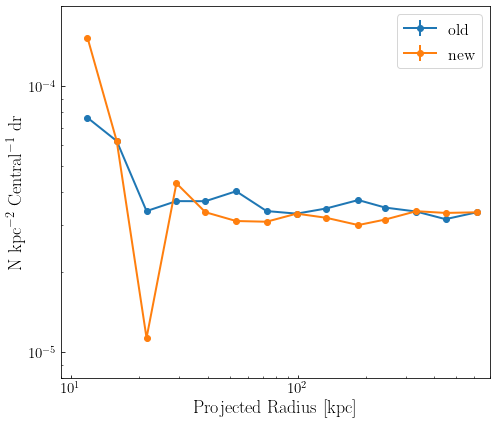

In [366]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.4

count_radial1 = np.load('CUT_deep_catalogs/COSMOS_deep_test_bkg.npy')
count_radial2 = np.load('CUT_deep_catalogs/COSMOS_deep_test_bkg_new.npy')

bin_centers = np.load(path1+'bin_centers.npy')

plt.errorbar(bin_centers, count_radial1,0,fmt='o-',linewidth=2,label='old')
plt.errorbar(bin_centers, count_radial2,0,fmt='o-',linewidth=2,label='new')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([8e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figures/bkg_flat.png')
plt.show(); plt.close()

In [122]:
def combine_deep_test_sat_z_cut(csfq, ssfq, masscut_low, masscut_high, z, a_z, path):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'_'+str(a_z)+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_elais, radial_xmmlss, radial_deep])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))


8.950996890929567
11.512861549636598
10.65578439892192


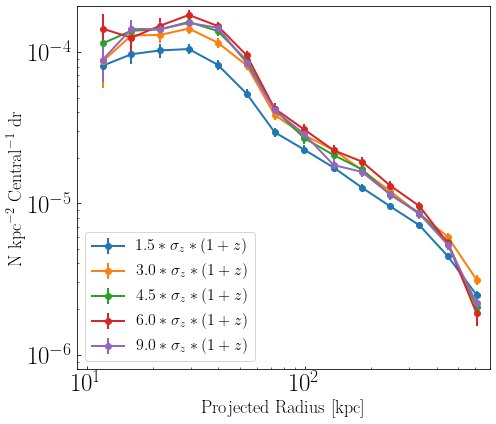

In [125]:
#test sat_z_cut a*sigma_z*(1+z)  a=1.5,3,4.5

# comparison between different isolation radius
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
z=0.4

path1 = 'CUT_deep_catalogs/test_sat_z_cut/'
count_radial1 = combine_deep_test_sat_z_cut('all','all','9.5','13.0',z,1.5,path=path1)
count_radial2 = combine_deep_test_sat_z_cut('all','all','9.5','13.0',z,3.0,path=path1)
count_radial3 = combine_deep_test_sat_z_cut('all','all','9.5','13.0',z,4.5,path=path1)
count_radial4 = combine_deep_test_sat_z_cut('all','all','9.5','13.0',z,6.0,path=path1)
count_radial5 = combine_deep_test_sat_z_cut('all','all','9.5','13.0',z,9.0,path=path1)
bin_centers = np.load(path1+'bin_centers.npy')

plt.errorbar(bin_centers, count_radial1[0],count_radial1[1],fmt='o-',linewidth=2,label='$1.5*\sigma_z*(1+z)$')
plt.errorbar(bin_centers, count_radial2[0],count_radial2[1],fmt='o-',linewidth=2,label='$3.0*\sigma_z*(1+z)$')
plt.errorbar(bin_centers, count_radial3[0],count_radial3[1],fmt='o-',linewidth=2,label='$4.5*\sigma_z*(1+z)$')
plt.errorbar(bin_centers, count_radial4[0],count_radial4[1],fmt='o-',linewidth=2,label='$6.0*\sigma_z*(1+z)$')
plt.errorbar(bin_centers, count_radial5[0],count_radial5[1],fmt='o-',linewidth=2,label='$9.0*\sigma_z*(1+z)$')
print(sum(count_radial1[0]*areas))
print(sum(count_radial2[0]*areas))
print(sum(count_radial3[0]*areas))

plt.xscale('log')
plt.yscale('log')  
plt.xlim([9,700])
plt.ylim([8e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figures/sat_z_cut.png')
plt.show(); plt.close()

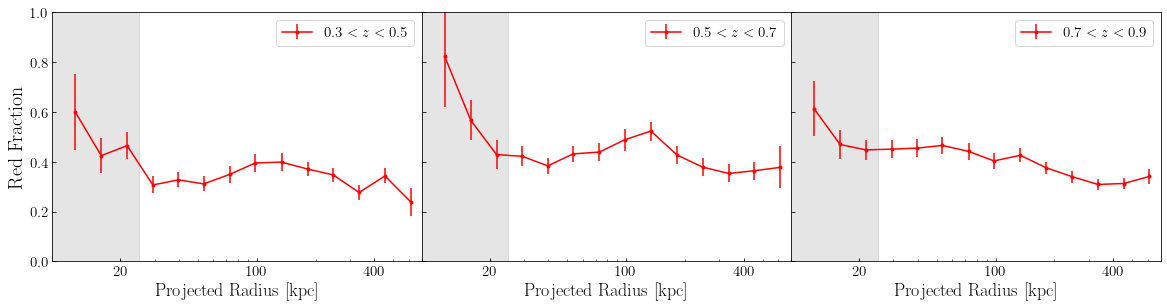

In [22]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,4))
red_frac_4 = count_radial_4_q[0] / count_radial_4[0]
red_frac_6 = count_radial_6_q[0] / count_radial_6[0]
red_frac_8 = count_radial_8_q[0] / count_radial_8[0]

red_err_4 = red_frac_err(count_radial_4_q[0],count_radial_4_sf[0],count_radial_4_q[1],count_radial_4_sf[1])
red_err_6 = red_frac_err(count_radial_6_q[0],count_radial_6_sf[0],count_radial_6_q[1],count_radial_6_sf[1])
red_err_8 = red_frac_err(count_radial_8_q[0],count_radial_8_sf[0],count_radial_8_q[1],count_radial_8_sf[1])

axs[0].errorbar(bin_edges, red_frac_4,yerr=red_err_4,fmt='.-r',label=r'$0.3<z<0.5$')
axs[1].errorbar(bin_edges, red_frac_6,yerr=red_err_6,fmt='.-r',label=r'$0.5<z<0.7$')
axs[2].errorbar(bin_edges, red_frac_8,yerr=red_err_8,fmt='.-r',label=r'$0.7<z<0.9$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axs[0].set_xlabel('Projected Radius [kpc]', fontsize=18)
axs[1].set_xlabel('Projected Radius [kpc]', fontsize=18)
axs[2].set_xlabel('Projected Radius [kpc]', fontsize=18)

axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xscale('log')
axs[0].set_xlim([9,700])
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_ylim([0,1])
axs[0].set_ylabel('Red Fraction',fontsize=20)
plt.savefig('figures/number_density_zdependence_'+model+'.red_frac.png',dpi=150)

In [93]:
# combine redshift bins

path = 'CUT_deep_catalogs/total_sample_show_bkg_newz/'
radial_all = np.zeros(14)
radial_all_err_square = np.zeros(14)
radial_ssf = np.zeros(14)
radial_ssf_err_square = np.zeros(14)
radial_sq = np.zeros(14)
radial_sq_err_square = np.zeros(14)
count_all = 0
count_ssf = 0
count_sq = 0
for z in [0.4, 0.6, 0.8]:
    radial_z_all = combine_deep('all','all','9.5','13.0', z, path=path)
    count_all += radial_z_all[2]
    radial_all += radial_z_all[0]*radial_z_all[2]
    radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
    radial_z_ssf = combine_deep('all','ssf','9.5','13.0', z, path=path)
    count_ssf += radial_z_ssf[2]
    radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
    radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
    radial_z_sq = combine_deep('all','sq','9.5','13.0', z, path=path)
    count_sq += radial_z_sq[2]
    radial_sq += radial_z_sq[0]*radial_z_sq[2]
    radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

radial_all = (radial_all/count_all,np.sqrt(radial_all_err_square)/count_all)
radial_ssf = (radial_ssf/count_ssf,np.sqrt(radial_ssf_err_square)/count_ssf)
radial_sq = (radial_sq/count_sq,np.sqrt(radial_sq_err_square)/count_sq)

np.savetxt(path+'all_field_9.5_all_'+ 'all'+'.txt', radial_all)
np.savetxt(path+'all_field_9.5_all_'+ 'ssf'+'.txt', radial_ssf)
np.savetxt(path+'all_field_9.5_all_'+ 'sq'+'.txt', radial_sq)
print(path+'all_field_9.5_all_'+ 'all'+'.txt')

[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
CUT_deep_catalogs/total_sample_show_bkg_newz/all_field_9.5_all_all.txt


OSError: CUT_deep_catalogs/total_sample_0312/all_field_9.5_all_all.txt not found.

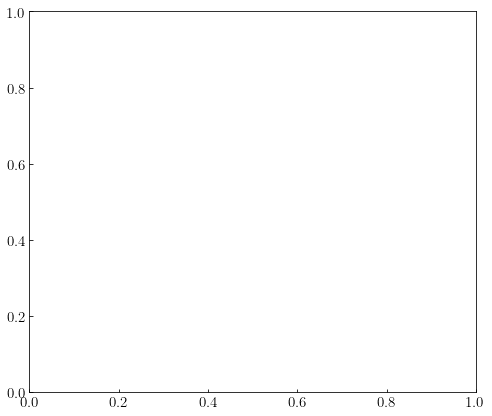

In [569]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
z='allz'

path = 'CUT_deep_catalogs/total_sample_show_bkg_newz/'
bin_edges = np.load(path+'bin_centers.npy')
count_radial_allz = np.genfromtxt(path+'all_field_9.5_all_all.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_9.5_all_ssf.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_9.5_all_sq.txt')
color=['k','b','r']
sat_type = ['All','SF','Q']
# dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom

for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_edges, radial[0],radial[1],fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)

#     model = 'NFW_Sersic'
#     popt_allz,pcov_allz,chi2_allz = fit_power(bin_edges,radial[0],radial[1], 4)
#     print('power',chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
#     popt_allz,pcov_allz,chi2_allz = fit_nfw(bin_edges,radial[0],radial[1], 4)
#     print('nfw',chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
plt.annotate(r'$0.3<z<0.9$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')


# prediction from DM mass distribution
rs_range1 = [119.4] # m_h from Leathaud et al. 2012
rs_range2 = [145.4] # m_h from Coupon et al. 2015
references = ['Leathaud+2012\&Ludlow+2014','Coupon+2015\&Ludlow+2014']
colors = ['g','y']
norm_to_value = nfw_sersic(bin_centers[-1], popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4])
for i,rs_range in enumerate([rs_range1,rs_range2]):
    for j,rs in enumerate(rs_range):
        norm_guess = 1e-4
        norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/norm_to_value)
        plt.plot(fit_x,nfw(fit_x,rs,norm),':'+colors[i],linewidth=2,label=references[i] if j==0 else'')
plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([8e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Distribution ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig('figures/number_density_allz.png')


## compare with Illustris-TNG simulation

[231, 69, 277, 219, 217]
r_s obs 219.56037327902055 54.2929340259662


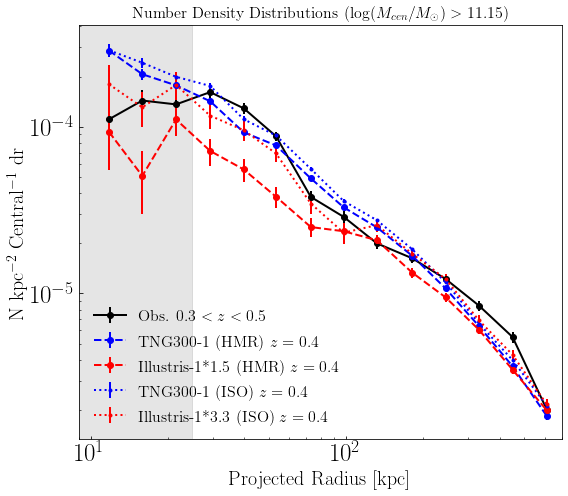

In [119]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
path = 'CUT_deep_catalogs/total_sample_45_SXDS3/'

count_radial_4 = combine_deep('all','all','9.5','13.0',0.4,path)

count_radial_tng = np.load('radial_tng_4.npy')  
count_radial_tng[1] = count_radial_tng[1]/areas/count_radial_tng[2]
count_radial_tng[0] = count_radial_tng[0]/areas/count_radial_tng[2]

count_radial_il = np.load('radial_il_4.npy')  
count_radial_il[1] = count_radial_il[1]/areas/count_radial_il[2]
count_radial_il[0] = count_radial_il[0]/areas/count_radial_il[2]

count_radial_tng_old = np.load('radial_tng_4_old.npy')  
count_radial_tng_old[1] = count_radial_tng_old[1]/areas/count_radial_tng_old[2]
count_radial_tng_old[0] = count_radial_tng_old[0]/areas/count_radial_tng_old[2]

count_radial_il_old = np.load('radial_il_4_old.npy')  
count_radial_il_old[1] = count_radial_il_old[1]/areas/count_radial_il_old[2]
count_radial_il_old[0] = count_radial_il_old[0]/areas/count_radial_il_old[2]

plt.errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='-ok',label=r'Obs. $0.3<z<0.5$',linewidth=2)
plt.errorbar(bin_edges, count_radial_tng[0], yerr=count_radial_tng[1], fmt='--ob',linewidth=2,label=r'TNG300-1 (HMR) $z=0.4$')
plt.errorbar(bin_edges, count_radial_il[0]*1.5, yerr=count_radial_il[1]*np.sqrt(1.5), fmt='--or',linewidth=2,label=r'Illustris-1*1.5 (HMR) $z=0.4$')

plt.errorbar(bin_edges, count_radial_tng_old[0], yerr=count_radial_tng[1], fmt='.:b',linewidth=2,label=r'TNG300-1 (ISO) $z=0.4$')
plt.errorbar(bin_edges, count_radial_il_old[0]*3.3, yerr=count_radial_il[1]*np.sqrt(3.3), fmt='.:r',linewidth=2,label=r'Illustris-1*3.3 (ISO) $z=0.4$')

# rs_range1 = [106.4,119.4,153.0] # m_h from Leathaud et al. 2012
# rs_range2 = [134.4,145.4,177.0] # m_h from Coupon et al. 2015

rs_range1 = [119.4] # m_h from Leathaud et al. 2012
rs_range2 = [145.4] # m_h from Coupon et al. 2015

# references = ['Leathaud et al. 2012',Leathaud et al. 2012']
# colors = ['g','y']
# for i,rs_range in enumerate([rs_range1,rs_range2]):
#     for rs in rs_range:
#         norm_guess = 1e-4
#         norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-35]/count_radial_4[0][-2])
#         plt.plot(fit_x,nfw(fit_x,rs,norm),':'+colors[i],linewidth=2)

# fitting
fit_x = np.linspace(2,700,num=100)
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
# popt_sim,pcov_sim,chi2_sim = fit_nfw_sersic(bin_edges,count_radial_sim,count_radial_4[1], start)
print('r_s obs',popt4[0],np.sqrt(np.diag(pcov4))[0])
# print('r_s sim',popt_sim[0],np.sqrt(np.diag(pcov_sim))[0])

# shade region
plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Distributions ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=16,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig('figures/TNG_Obs_compare.png')

[269, 115, 302, 272, 258]
[269, 115, 302, 272, 258]
[269, 115, 302, 272, 258]
r_s obs 219.56037327902055 54.2929340259662
r_s sim 228.01607551214684 51.710929488002236


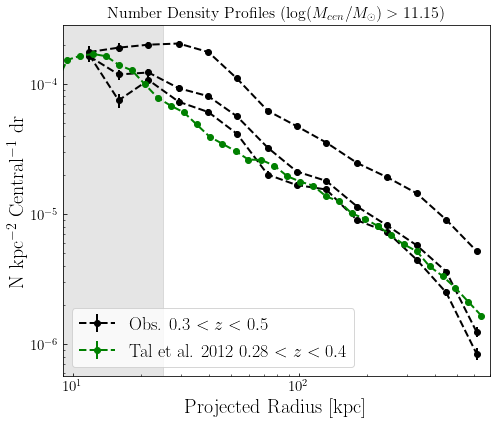

In [77]:
### compare with literature (Tal et al. 2012, Hartley et al. 2015)
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))

# count_radial_sim = np.load('TNG_z0_radial.npy')
count_radial_sim = np.load('radial_tot_0.4.npy')  
count_radial_sim = count_radial_sim/areas/779
count_radial_il = np.load('radial_tot_il_0.4.npy')  
count_radial_tal = np.genfromtxt('tal.txt')
count_radial_har = np.genfromtxt('hartley.txt')

path = 'CUT_deep_catalogs/total_sample/'
count_radial_41 = combine_deep(csfq,'all','9.5','13.0',0.4,path)
count_radial_42 = combine_deep(csfq,'all','10.0','13.0',0.4,path)
count_radial_43 = combine_deep(csfq,'all','10.2','13.0',0.4,path)
plt.errorbar(bin_edges, count_radial_41[0]*2,count_radial_41[1],fmt='--ok',linewidth=2)
plt.errorbar(bin_edges, count_radial_42[0]*2,count_radial_42[1],fmt='--ok',linewidth=2)
plt.errorbar(bin_edges, count_radial_43[0]*2,count_radial_43[1],fmt='--ok',label=r'Obs. $0.3<z<0.5$',linewidth=2)

# plt.errorbar(bin_edges, count_radial_sim,0,fmt='--ob',linewidth=2,label=r'TNG300-1 $z=0.4$')
# plt.errorbar(bin_edges, count_radial_il*3.3,0,fmt='--or',linewidth=2,label=r'Illustris-1 $z=0.4$')
plt.errorbar(count_radial_tal[:,0], count_radial_tal[:,1],0,fmt='--og',linewidth=2,label=r'Tal et al. 2012 $0.28<z<0.4$')
# plt.errorbar(count_radial_har[:,0], count_radial_har[:,1],0,fmt='--oy',linewidth=2,label=r'Hartley et al. 2015 $0.4<z<1.3$')

# fitting
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt_sim,pcov_sim,chi2_sim = fit_nfw_sersic(bin_edges,count_radial_sim,count_radial_4[1], start)
print('r_s obs',popt4[0],np.sqrt(np.diag(pcov4))[0])
print('r_s sim',popt_sim[0],np.sqrt(np.diag(pcov_sim))[0])

# shade region
plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Profiles ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('figures/Obs_liter_compare.png')


## Split for Satellite Mass

In [ ]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

def red_frac_err_new(q, All, q_err, all_err):
    return np.sqrt( q_err**2*(1/All)**2 + all_err**2*(q/All**2)**2)

# [plt.fill_between] move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

0 0 [4.160e+02 1.474e-05 3.133e-05 1.033e+01 1.667e-01] [1.405e+02 5.145e-06 2.163e-05 1.459e+04 2.191e-01]
0 1 [3.998e+02 1.088e-05 2.376e-05 3.558e+01 2.279e-01] [5.328e+01 1.532e-06 4.713e-06 5.408e+00 1.210e-01]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


0 2 [2.629e+02 1.639e-05 3.664e-05 8.239e+00 1.667e-01] [2.919e+01 2.171e-06 6.137e-06 6.079e+02 2.679e-03]
0 3 [4.599e+02 6.745e-06 1.701e-05 3.669e+01 2.924e-01] [3.914e+01 5.945e-07 2.193e-06 2.185e+00 1.077e-01]
1 1 [3.371e+02 8.803e-06 8.657e-06 1.457e+01 1.667e-01] [6.034e+01 1.788e-06 2.673e-06 1.132e+04 1.439e-01]
1 2 [2.267e+02 1.618e-05 2.602e-05 9.538e+00 1.667e-01] [2.980e+01 2.571e-06 7.209e-06 4.859e+03 6.189e-02]
1 3 [3.260e+02 8.019e-06 1.797e-05 3.991e+01 7.203e-01] [7.553e+01 2.236e-06 5.215e-06 6.850e+00 5.437e-01]
2 1 [7.814e+02 4.444e-06 1.875e-05 2.644e+01 3.927e-01] [2.356e+02 1.096e-06 2.031e-05 1.064e+01 9.312e-01]
2 2 [5.439e+02 6.207e-06 1.906e-05 3.087e+01 4.514e-01] [7.556e+01 8.136e-07 5.935e-06 4.351e+00 3.652e-01]
2 3 [2.926e+02 1.143e-05 2.530e-05 2.680e+01 3.128e-01] [2.356e+01 1.028e-06 6.940e-06 2.337e+00 2.010e-01]


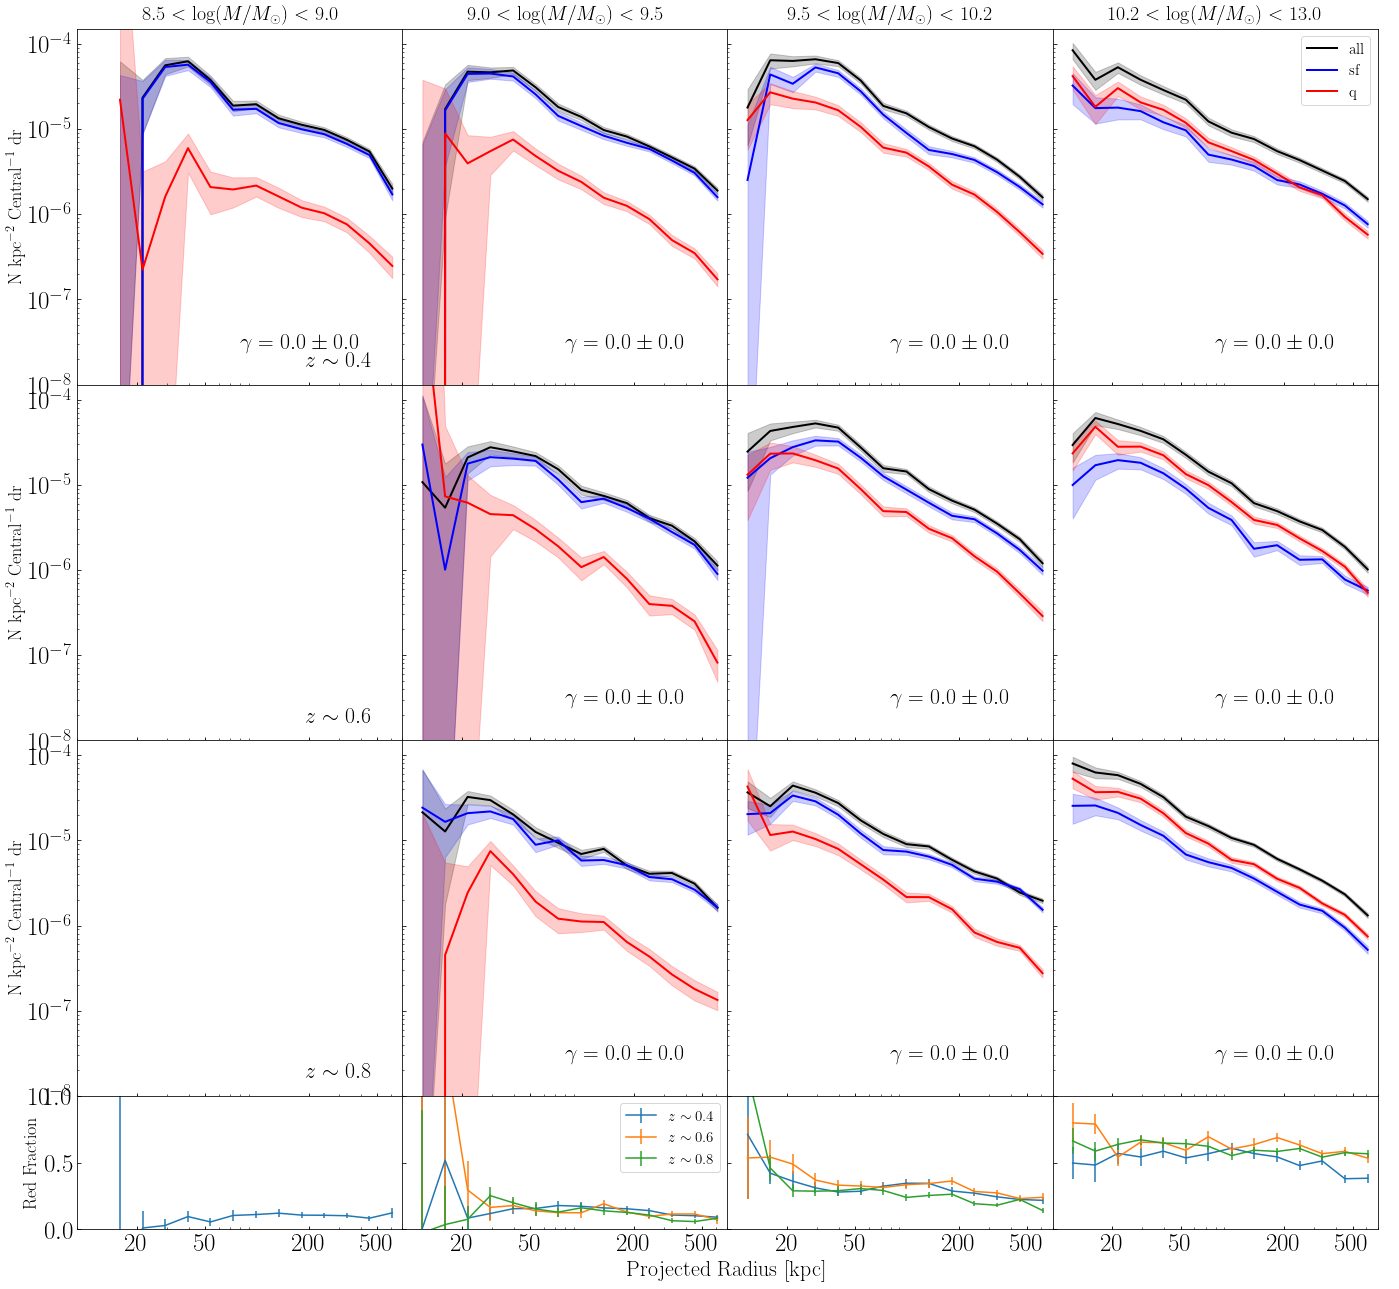

In [108]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey='row', figsize = (20, 18.5),gridspec_kw={'height_ratios':[4,4,4,1.5]})
path_old = 'CUT_deep_catalogs/split_sat_mass_new/'
path = 'CUT_deep_catalogs/split_sat_mass_newer/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead
bin_centers = np.load(path+'bin_centers.npy')

for i in range(3):
    z = i*0.2 + 0.4
    axs[i][0].annotate('$z\sim'+str(round(z,1))+'$',xy=(0.7,0.05),xycoords='axes fraction',fontsize=22)
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [8.5,9.0,9.5,10.2,13.0]
    for j in range(4):
        if i==0 and j==0:
            axs[0][j].set_title('$8.5<\log(M/M_\odot)<9.0$',fontsize=20)
            radial_all = combine_deep('all','all','8.5','9.0', 0.3, path=path_old) 
            radial_sf = combine_deep('all','ssf','8.5','9.0', 0.3, path=path_old)
            radial_q = combine_deep('all','sq','8.5','9.0', 0.3, path=path_old)
        elif j==0:
            continue
        else:
            axs[0][j].set_title('$'+str(mass_range[j])+'<\log(M/M_\odot)<'+str(mass_range[j+1])+'$',fontsize=20)
            radial_all = combine_deep('all','all',str(mass_range[j]),str(mass_range[j+1]), z, path=path) 
            radial_sf = combine_deep('all','ssf',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
            radial_q = combine_deep('all','sq',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
        
        fit_x = np.linspace(2,700,num=100)
        popt,pcov,chi2 = fit_nfw_sersic(bin_centers,radial_all[0],radial_all[1], start)
        perr = np.sqrt(np.diag(pcov))
        print(i,j,popt,perr)
        
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        axs[i][j].plot(bin_centers, radial_all[0],color='k',linewidth=2,label='all')
        axs[i][j].fill_between(bin_centers,radial_all[0]+radial_all[1],
                               aa(radial_all[0]-radial_all[1]), alpha=0.2, color='k')
        
        axs[i][j].plot(bin_centers, radial_sf[0],color='b',linewidth=2,label='sf')
        axs[i][j].fill_between(bin_centers,radial_sf[0]+radial_sf[1],
                               aa(radial_sf[0]-radial_sf[1]), alpha=0.2, color='b')
        
        axs[i][j].plot(bin_centers, radial_q[0],color='r',linewidth=2,label='q')
        axs[i][j].fill_between(bin_centers,radial_q[0]+radial_q[1],
                               aa(radial_q[0]-radial_q[1]), alpha=0.2, color='r')
        
        axs[i][j].plot(fit_x,power_law(fit_x, popt[0],popt[1]),'--k',alpha=0.7)
        axs[i][j].annotate('$\gamma='+str(round(popt[1],2))+'\pm'+str(round(perr[1],2))+'$',
                           xy=(0.5,0.1),xycoords='axes fraction',fontsize=22)
        
        axs[3][j].errorbar(bin_edges, red_frac,yerr=red_err,label='$z\sim'+str(round(z,1))+'$')

#=============================
axs[0][0].set_ylim([1e-8,1.5e-4])
axs[0][0].set_xlim([9,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')

axs[1][0].set_ylim([1e-8,1.5e-4])
axs[1][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[2][0].set_ylim([1e-8,1.5e-4])
axs[2][0].set_yscale('log')
axs[2][0].set_xscale('log')

axs[3][0].set_ylim([0,1])
axs[0][0].set_xticks([20, 50, 200, 500])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[3][0].set_ylabel('Quiescent Fraction',fontsize=18)
axs[0][3].legend(fontsize=15)
axs[3][1].legend(fontsize=15)
        
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=22)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_mass_redfraction.png')
plt.show()

[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
No. of sats, total: 6.03 sf: 4.6 q: 1.12 q-frac, 0.19
[4.455e+02 9.736e-06 3.277e-05 3.005e+01 4.052e-01] [1.185e+02 2.623e-06 1.681e-05 6.590e+00 5.741e-01] Chi2_dof=3.51
[6.087e+02 5.392e-06 3.182e-05 2.927e+01 3.933e-01] [1.638e+02 1.340e-06 1.235e-05 4.696e+00 4.219e-01] Chi2_dof=2.14
[1.919e+02 4.827e-06 9.556e-06 8.834e+00 1.667e-01] [3.468e+01 1.081e-06 2.986e-06 2.116e+03 3.149e-02] Chi2_dof=0.69
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
No. of sats, total: 4.76 sf: 1.95 q: 2.54 q-frac, 0.53
[2.554e+02 1.450e-05 2.472e-05 2.484e+01 1.875e-01] [4.154e+01 2.708e-06 8.605e-06 2.199e+01 1.720e-01] Chi2_dof=1.97
[4.104e+02 3.303e-06 1.194e-05 3.143e+01 1.890e+00] [1.426e+02 1.386e-06 9.292e-06 1.301e+01 3.130e+00] Chi2_dof=0.36
[2.692e+02 7.002e-06 1.810e-05 3.280e+01 8.659e-01] [1.171e+02 3.813e-06 1.317e-05 1.234e+01 1.415e+00] Chi2_dof=2.98


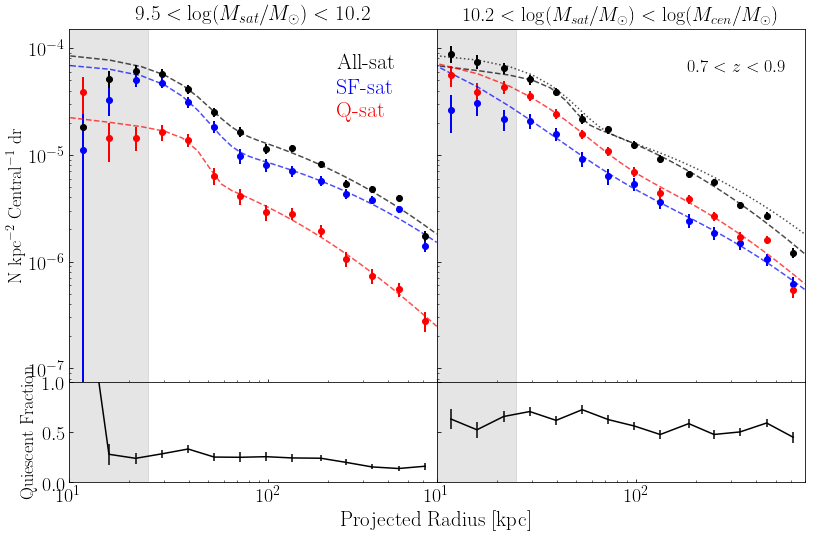

In [16]:
# combine redshift bins
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (12, 8),gridspec_kw={'height_ratios':[3.5,1]})
np.set_printoptions(precision=3)
start=4
z=0.8
path = 'CUT_deep_catalogs/split_sat_mass_45_newz/'
bin_centers = np.load(path+'bin_centers.npy')

for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.2,13.0]
    for j in range(2):
        radial_all = combine_deep('all','all',mass_range[j],mass_range[j+1], z, path=path) 
        radial_sf = combine_deep('all','ssf',mass_range[j],mass_range[j+1], z, path=path) 
        radial_q = combine_deep('all','sq',mass_range[j],mass_range[j+1], z, path=path) 
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        print('No. of sats, total:',round(sum(radial_all[0]*areas),2),
              'sf:',round(sum(radial_sf[0]*areas),2),
              'q:',round(sum(radial_q[0]*areas),2),
             'q-frac,',round(sum(radial_q[0]*areas)/sum(radial_all[0]*areas),2))
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].errorbar(bin_centers, radial[0],radial[1],fmt='o',color=color,linewidth=2,label='all')
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)   
            try:
                popt,pcov,chi2 = fit_nfw_sersic(bin_centers,radial[0],radial[1], start)
                perr = np.sqrt(np.diag(pcov))
                dof = len(bin_centers)-start+1 - len(popt) # degree of freedom
                print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))
                axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
            except RuntimeError:
                print('Cannot Fit')
                
            if j==0 and color  =='k':
                axs[0][1].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),':k',alpha=0.7)
        
        # red fraction
        axs[1][j].errorbar(bin_centers, red_frac, yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1.5e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Quiescent Fraction',fontsize=18)
axs[0][0].set_title('$9.5<\log(M_{sat}/M_\odot)<10.2$',fontsize=21)
axs[0][1].set_title('$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',fontsize=20)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
axs[0][1].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(z+0.1)+'$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_'+str(z)+'.png')
plt.show(); plt.close()

In [95]:
# combine redshift bins

path = 'CUT_deep_catalogs/split_sat_mass_45_newbkg_newz/'
masscut_lim = [9.5, 10.2,13.0]
for masslow_id in range(len(masscut_lim)-1):
    radial_all = np.zeros(14)
    radial_all_err_square = np.zeros(14)
    radial_ssf = np.zeros(14)
    radial_ssf_err_square = np.zeros(14)
    radial_sq = np.zeros(14)
    radial_sq_err_square = np.zeros(14)
    count_all = 0
    count_ssf = 0
    count_sq = 0
    for z in [0.4, 0.6, 0.8]:
        radial_z_all = combine_deep('all','all',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_all += radial_z_all[2]
        radial_all += radial_z_all[0]*radial_z_all[2]
        radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
        radial_z_ssf = combine_deep('all','ssf',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_ssf += radial_z_ssf[2]
        radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
        radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
        radial_z_sq = combine_deep('all','sq',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_sq += radial_z_sq[2]
        radial_sq += radial_z_sq[0]*radial_z_sq[2]
        radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

    radial_all = (radial_all/count_all,np.sqrt(radial_all_err_square)/count_all)
    radial_ssf = (radial_ssf/count_ssf,np.sqrt(radial_ssf_err_square)/count_ssf)
    radial_sq = (radial_sq/count_sq,np.sqrt(radial_sq_err_square)/count_sq)

    np.savetxt(path+'all_field_'+ str(masscut_lim[masslow_id]) + '_all_'+ 'all'+'.txt', radial_all)
    np.savetxt(path+'all_field_'+ str(masscut_lim[masslow_id]) + '_all_'+ 'ssf'+'.txt', radial_ssf)
    np.savetxt(path+'all_field_'+ str(masscut_lim[masslow_id]) + '_all_'+ 'sq'+'.txt', radial_sq)
    print

[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]
[470, 85, 559, 405, 385]


No. of sats, total: 5.87 sf: 4.6 q: 1.35
[3.286e+02 1.293e-05 4.763e-05 3.438e+01 3.667e-01] [6.921e+01 3.042e-06 8.936e-06 2.988e+00 1.972e-01] Chi2_dof=4.69
[3.360e+02 1.001e-05 3.810e-05 3.240e+01 2.725e-01] [7.869e+01 2.564e-06 7.867e-06 3.695e+00 2.016e-01] Chi2_dof=4.97
[1.636e+02 7.224e-06 1.158e-05 9.684e+00 1.667e-01] [3.123e+01 1.788e-06 3.521e-06 5.111e+03 7.660e-02] Chi2_dof=2.18
No. of sats, total: 5.08 sf: 2.38 q: 2.89
[3.803e+02 9.530e-06 2.608e-05 3.470e+01 6.236e-01] [8.181e+01 2.263e-06 8.314e-06 5.989e+00 5.339e-01] Chi2_dof=3.94
[5.166e+02 3.221e-06 9.711e-06 3.769e+01 6.361e-01] [1.173e+02 7.472e-07 2.852e-06 6.366e+00 5.248e-01] Chi2_dof=1.71
[3.536e+02 5.890e-06 1.492e-05 3.463e+01 4.264e-01] [5.912e+01 1.093e-06 3.687e-06 4.151e+00 2.977e-01] Chi2_dof=2.28


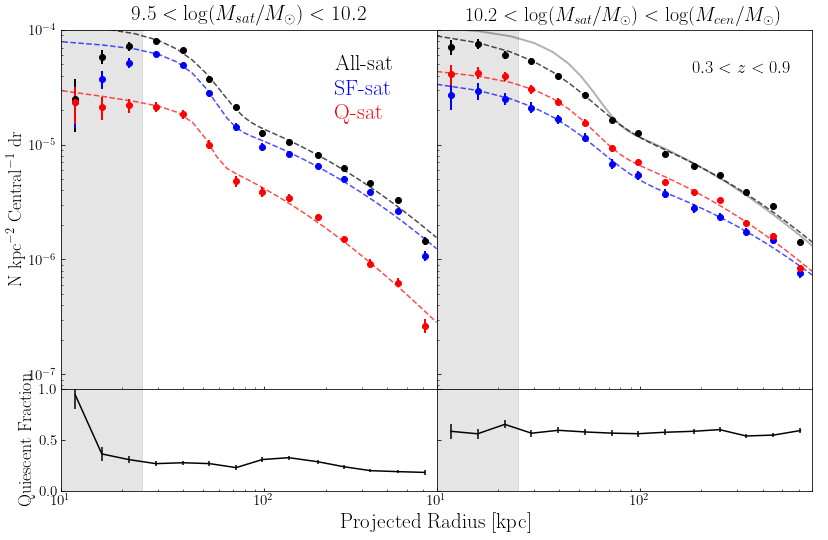

In [98]:
# combine redshift bins
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (12, 8),gridspec_kw={'height_ratios':[3.5,1]})
np.set_printoptions(precision=3)
start=4
path = 'CUT_deep_catalogs/split_sat_mass_45_newbkg_newz/'
bin_centers = np.load(path+'bin_centers.npy')

for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.2,13.0]
    for j in range(2):
        radial_all = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_all.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_ssf.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_sq.txt')
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        print('No. of sats, total:',round(sum(radial_all[0]*areas),2),
              'sf:',round(sum(radial_sf[0]*areas),2),
              'q:',round(sum(radial_q[0]*areas),2))
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].errorbar(bin_centers, radial[0],radial[1],fmt='o',color=color,linewidth=2,label='all')
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_centers,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            dof = len(bin_centers)-start+1 - len(popt) # degree of freedom
            print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
            if j==0 and color=='k':
                axs[0][1].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1]*0.85,popt[2],popt[3],popt[4]),color,alpha=0.3,linewidth=2)
        # red fraction
        axs[1][j].errorbar(bin_centers, red_frac, yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Quiescent Fraction',fontsize=18)
axs[0][0].set_title('$9.5<\log(M_{sat}/M_\odot)<10.2$',fontsize=21)
axs[0][1].set_title('$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',fontsize=20)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
axs[0][1].annotate(r'$0.3<z<0.9$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_allz.png')
plt.show(); plt.close()

[2.424e+02 1.087e-05 1.715e-05 3.037e+01 2.422e-01] [3.037e+01 1.621e-06 4.014e-06 5.389e+00 2.329e-01] Chi2_dof=3.81
[2.698e+02 7.165e-06 1.258e-05 3.155e+01 2.411e-01] [4.689e+01 1.452e-06 3.532e-06 7.853e+00 2.855e-01] Chi2_dof=4.5
[1.606e+02 4.225e-06 3.449e-06 2.842e+01 1.959e-01] [1.694e+01 5.901e-07 9.800e-07 2.313e+01 2.471e-01] Chi2_dof=1.03
[2.358e+02 8.724e-06 1.158e-05 3.300e+01 6.022e-01] [3.843e+01 1.800e-06 4.754e-06 6.942e+00 6.374e-01] Chi2_dof=3.32
[2.809e+02 3.964e-06 6.744e-06 3.169e+01 4.783e-01] [4.535e+01 7.566e-07 2.723e-06 6.083e+00 5.170e-01] Chi2_dof=2.12
[1.532e+02 6.848e-06 4.034e-06 9.668e+00 1.667e-01] [1.869e+01 1.110e-06 1.941e-06 8.155e+03 1.177e-01] Chi2_dof=1.89
[1.958e+02 7.638e-06 8.893e-06 2.747e+01 2.158e-01] [2.958e+01 1.438e-06 3.485e-06 9.297e+00 2.471e-01] Chi2_dof=4.04
[2.328e+02 2.178e-06 2.495e-06 3.130e+01 3.524e-01] [3.266e+01 3.744e-07 9.494e-07 5.007e+00 4.185e-01] Chi2_dof=0.83
[1.289e+02 8.425e-06 2.263e-04 2.095e-02 1.453e+00] [2.35

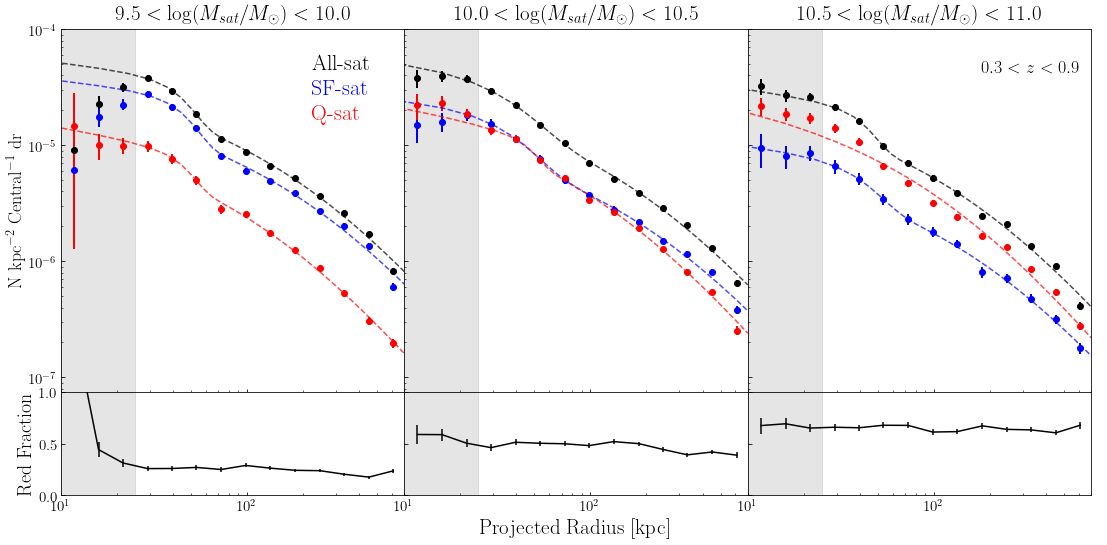

In [48]:
# combine redshift bins
fig, axs = plt.subplots(2, 3, sharex=True, sharey='row', figsize = (16, 8),gridspec_kw={'height_ratios':[3.5,1]})
path = 'CUT_deep_catalogs/split_sat_mass_3bins/'
bin_edges = np.load(path+'bin_centers.npy') 
bin_centers = np.load(path+'bin_centers.npy')
start = 4; fit_x = np.linspace(2,700,num=100) 

for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.0,10.5,11.0]
    for j in range(3):
        axs[0][j].set_title('$'+str(mass_range[j])+'<\log(M_{sat}/M_\odot)<'+str(mass_range[j+1])+'$',fontsize=21)
        radial_all = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_all.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_ssf.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_sq.txt')
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].errorbar(bin_centers, radial[0],radial[1],fmt='o',color=color,linewidth=2,label='all')
#             axs[i][j].fill_between(bin_centers,radial[0]+radial[1],aa(radial[0]-radial[1]), alpha=0.2, color=color)
        
            # model fitting       
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,radial[0],radial[1], start); perr = np.sqrt(np.diag(pcov))
            dof = len(bin_edges)-start+1 - len(popt) # degree of freedom
            print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
        
        # red fraction
        axs[1][j].errorbar(bin_centers, red_frac,yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Quiescent Fraction',fontsize=18)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
axs[0][2].annotate(r'$0.3<z<0.9$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_allz_3bins.png')
plt.show()
plt.close()

## Galaxy Conformity

In [112]:
# combine all three redshift bins

path = 'CUT_deep_catalogs/conformity_sfProb_newbkg_newz/'
matched = ''
# path = 'CUT_deep_catalogs/conformity_sfProb_matched_newbkg_newz/'
# matched='_matched'

radial_csf_ssf = np.zeros(14)
radial_csf_ssf_err = np.zeros(14)
radial_csf_sq = np.zeros(14)
radial_csf_sq_err = np.zeros(14)
radial_csf = np.zeros(14)
radial_csf_err = np.zeros(14)
radial_cq_ssf = np.zeros(14)
radial_cq_ssf_err = np.zeros(14)
radial_cq_sq = np.zeros(14)
radial_cq_sq_err = np.zeros(14)
radial_cq = np.zeros(14)
radial_cq_err = np.zeros(14)
count_csf = 0
count_cq = 0

for z in [0.4,0.6,0.8]:
    radial_csf_ssf_z = combine_deep('csf','ssf','9.5','inf',z, path)
    radial_csf_sq_z = combine_deep('csf','sq','9.5','inf',z, path)
    radial_csf_z = combine_deep('csf','all','9.5','inf',z, path)

    radial_cq_ssf_z = combine_deep('cq','ssf','9.5','inf',z, path)
    radial_cq_sq_z = combine_deep('cq','sq','9.5','inf',z, path)
    radial_cq_z = combine_deep('cq','all','9.5','inf',z, path)
    
    # csf, ssf
    radial_csf_ssf += radial_csf_ssf_z[0]*radial_csf_z[2]
    radial_csf_ssf_err += radial_csf_ssf_z[1]**2*radial_csf_ssf_z[2]**2
    
    # csf, sq
    radial_csf_sq += radial_csf_sq_z[0]*radial_csf_z[2]
    radial_csf_sq_err += radial_csf_sq_z[1]**2*radial_csf_ssf_z[2]**2
    
    #csf, all
    count_csf += radial_csf_z[2]
    radial_csf += radial_csf_z[0]*radial_csf_z[2]
    radial_csf_err += radial_csf_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, ssf
    radial_cq_ssf += radial_cq_ssf_z[0]*radial_cq_z[2]
    radial_cq_ssf_err += radial_cq_ssf_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, sq
    radial_cq_sq += radial_cq_sq_z[0]*radial_cq_z[2]
    radial_cq_sq_err += radial_cq_sq_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, all
    count_cq += radial_cq_z[2]
    radial_cq += radial_cq_z[0]*radial_cq_z[2]
    radial_cq_err += radial_cq_z[1]**2*radial_csf_ssf_z[2]**2
    print(z,radial_csf_z[2],radial_cq_z[2])

[41, 13, 48, 31, 36]
[41, 13, 48, 31, 36]
[41, 13, 48, 31, 36]
[190, 56, 229, 186, 181]
[190, 56, 229, 186, 181]
[190, 56, 229, 186, 181]
0.4 169 842
[28, 11, 26, 13, 40]
[28, 11, 26, 13, 40]
[28, 11, 26, 13, 40]
[213, 81, 293, 203, 244]
[213, 81, 293, 203, 244]
[213, 81, 293, 203, 244]
0.6 118 1034
[48, 7, 54, 41, 43]
[48, 7, 54, 41, 43]
[48, 7, 54, 41, 43]
[422, 78, 505, 364, 342]
[422, 78, 505, 364, 342]
[422, 78, 505, 364, 342]
0.8 193 1711


9.793666360360675
12.443922945015228
Q-frac for cen-SF 0.286 0.045
Q-frac for cen-Q 0.372 0.002


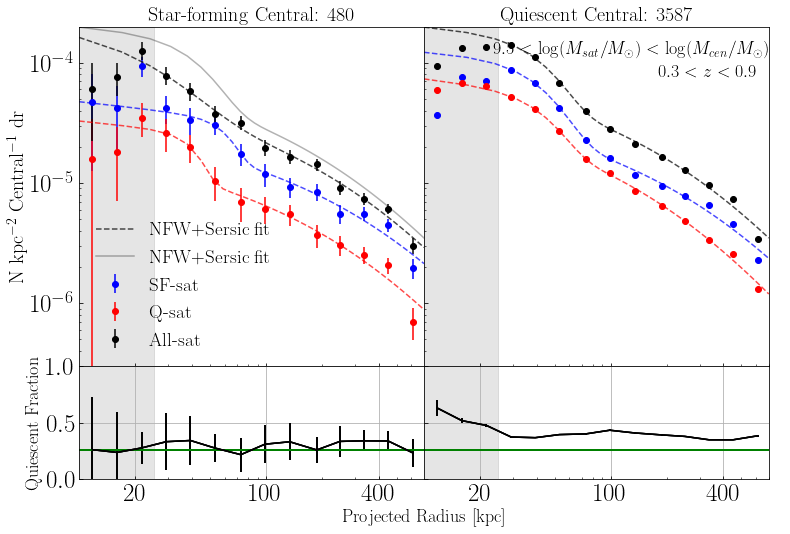

In [113]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
np.set_printoptions(precision=3)
z = 'allz'
q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(0.6*10%2)-1]

if isinstance(z,str):
    radial_csf_ssf = (radial_csf_ssf/count_csf, np.sqrt(radial_csf_ssf_err)/count_csf,count_csf)
    radial_csf_sq = (radial_csf_sq/count_csf,np.sqrt(radial_csf_sq_err)/count_csf,count_csf)
    radial_csf = (radial_csf/count_csf,np.sqrt(radial_csf_err)/count_csf,count_csf)
    radial_cq_ssf = (radial_cq_ssf/count_cq,np.sqrt(radial_cq_ssf_err)/count_cq,count_cq)
    radial_cq_sq = (radial_cq_sq/count_cq,np.sqrt(radial_cq_sq_err)/count_cq,count_cq)
    radial_cq = (radial_cq/count_cq,np.sqrt(radial_cq_err)/count_cq,count_cq)
    axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g') # field value
    axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g') # field value
    z_range = r'$0.3<z<0.9$'
else:
    path = 'CUT_deep_catalogs/conformity_sfProb_newbkg_newz/'; matched=''
#     path = 'CUT_deep_catalogs/conformity_matched_central_mass_0723/'; matched='_matched'
    radial_csf_ssf = combine_deep('csf','ssf','9.5','inf',z, path)
    radial_csf_sq = combine_deep('csf','sq','9.5','inf',z, path)
    radial_csf = combine_deep('csf','all','9.5','inf',z, path)
    radial_cq_ssf = combine_deep('cq','ssf','9.5','inf',z, path)
    radial_cq_sq = combine_deep('cq','sq','9.5','inf',z, path)
    radial_cq = combine_deep('cq','all','9.5','inf',z, path)
    q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(z*10%2)-1]
    axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g') # field value
    axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g') # field value
    z_range = r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$'

# print total number of sats per central
print(sum(radial_csf[0]*areas))
print(sum(radial_cq[0]*areas))

radial_list = [radial_csf_ssf, radial_csf_sq, radial_csf, radial_cq_ssf, radial_cq_sq, radial_cq]
bin_centers = np.load(path+'bin_centers.npy')
colors=['b','r','k']; sat_types = ['SF','Q','All']; central_types = ['cen-SF','cen-Q']

# plotting
fit_x = np.linspace(10,700,num=100)
for i,radial in enumerate(radial_list):
    
    # number density distribution
    label='NFW+Sersic fit' if i%3==2 else ''
    axs[0][int(i/3)].errorbar(bin_centers, radial[0],radial[1], fmt='o'+colors[i%3],label=sat_types[i%3]+'-sat')
    popt,pocv,chi2 = fit_nfw_sersic(bin_centers,radial[0],radial[1],4)
    axs[0][int(i/3)].plot(fit_x,nfw_sersic(fit_x,popt[0],popt[1],popt[2],popt[3],popt[4]),
                          '--'+colors[i%3],alpha=0.7,label=label)
    if i==5:
        axs[0][0].plot(fit_x,nfw_sersic(fit_x,popt[0],popt[1],popt[2],popt[3],popt[4]),
                          '-'+colors[i%3],alpha=0.3,label=label,linewidth=1.5)
        
    #red fraction
    red_frac = radial_list[int(i/3)*3+1][0]/radial_list[int(i/3)*3+2][0]
    redfrac_err = red_frac_err_new(radial_list[int(i/3)*3+1][0],radial_list[int(i/3)*3][0],radial_list[int(i/3)*3+1][1],radial_list[int(i/3)*3][1])
    axs[1][int(i/3)].errorbar(bin_centers, red_frac, fmt='k',yerr=redfrac_err)
    if i%3==2: print('Q-frac for '+central_types[int(i/3)],round(np.average(red_frac[2:],weights=areas[2:]),3),
        round(np.sqrt(sum(redfrac_err[2:]**2))/len(redfrac_err[2:]**2),3)) 
    
# add shaded regions
for panel in [[0,0],[0,1],[1,0],[1,1]]:
    axs[panel[0]][panel[1]].axvspan(10, 25, alpha=0.1, color='k') 

# plotting configurations
axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=20)
axs[1][0].set_ylabel('Quiescent Fraction', fontsize=18)
axs[0][0].set_title('Star-forming Central: '+str(radial_list[2][2]),fontsize=20)
axs[0][1].set_title('Quiescent Central: '+str(radial_list[5][2]),fontsize=20)
axs[0][1].annotate(z_range,xy=([0.68,0.85]),xycoords='axes fraction',fontsize=18,color='k')
axs[0][1].annotate('$9.5<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',xy=([0.2,0.91]),xycoords='axes fraction',fontsize=18,color='k')
axs[0][0].legend(fontsize=19,frameon=False)
axs[0][0].set_xlim([10,700])
axs[0][0].set_ylim([3e-7,2e-4])
axs[1][0].set_ylim([0,1])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1][0].grid(True)
axs[1][1].grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/splitting_central_sfq_'+str(z)+str(matched)+'.png')
plt.show()

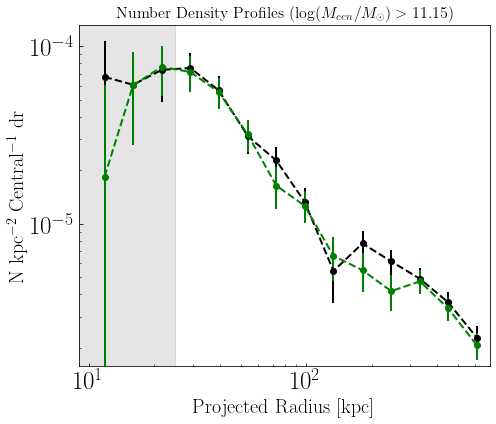

In [121]:
# matched mass distribution vs not matched

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))
path1 = 'CUT_deep_catalogs/conformity_sfProb/'
path2 = 'CUT_deep_catalogs/conformity_matched_central_mass_0723/'

# affix = '_9.5_csf_all_0.4.txt'
# field = 'COSMOS_deep'
# count_radial_full1 = np.genfromtxt(path1+'count'+field+affix)
# split_index = int(((len(count_radial_full1)-1)/2)+1)
# count_radial1 = count_radial_full1[1:split_index]
# count_radial1_err = count_radial_full1[split_index:]
# count_radial1 = (count_radial1,count_radial1_err)


# count_radial_full2 = np.genfromtxt(path2+'count'+field+affix)
# count_radial2 = count_radial_full2[1:split_index]
# count_radial2_err = count_radial_full2[split_index:]
# count_radial2 = (count_radial2,count_radial2_err)
# print(count_radial2)

count_radial1 = combine_deep('csf','all','9.5','13.0',0.4,path1)
count_radial2 = combine_deep('csf','all','9.5','13.0',0.4,path2)

plt.errorbar(bin_edges, count_radial1[0],count_radial1[1],fmt='--ok',linewidth=2)
plt.errorbar(bin_edges, count_radial2[0],count_radial2[1],fmt='--og',linewidth=2)

# shade region
plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Profiles ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
# plt.legend(fontsize=18)
plt.tight_layout()

## Link Through Redshift

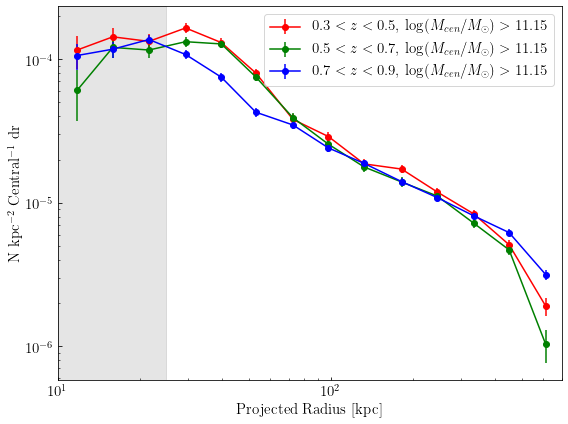

In [20]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

# path = 'CUT_deep_catalogs/total_sample_evo_masscut_0713/'  # evolving mass cut
# slope = 0.16
# masscut_z0 = 11.23
# masscut_type = 'evolving'

path = 'CUT_deep_catalogs/total_sample_45_SXDS3/' # constant mass cut
slope = 0
masscut_z0 = 11.15
masscut_type = 'constant'

radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.4)+'$')
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.6)+'$')
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.8)+'$')
plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])
plt.tight_layout()
plt.savefig('figures/radial_evolution_'+masscut_type+'_masscut.png')
plt.show()

[231, 69, 277, 217, 217]
[241, 92, 319, 216, 284]
[470, 85, 559, 405, 385]
[215, 62, 250, 199, 201]
[255, 96, 345, 224, 292]
[532, 103, 664, 439, 435]
[215, 62, 250, 199, 201]
[255, 96, 345, 224, 292]
[532, 103, 664, 439, 435]


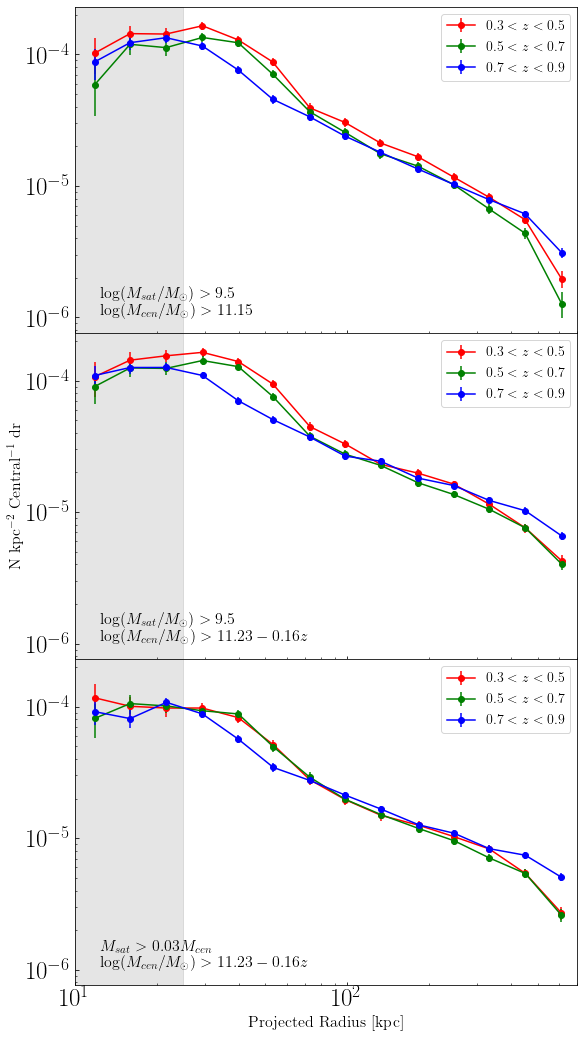

In [115]:
fig, axs = plt.subplots(3, 1, sharex=True,sharey=True, figsize=(9,18))

# panel 1
path = 'CUT_deep_catalogs/total_sample_newz/'  # evolving mass cut
slope = 0
masscut_z0 = 11.15

radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[0].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[0].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[0].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[0].axhline(2e-5,10,700,linewidth=4, color='r')
axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=14)

# panel 2
path = 'CUT_deep_catalogs/total_sample_evo_cen_masscut_newbkg_newz/'  # evolving mass cut
slope = 0.16
masscut_z0 = 11.23

radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[1].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[1].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[1].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[1].axhline(2e-5,10,700,linewidth=4, color='r')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[1].legend(fontsize=14)

# panel 3
path = 'CUT_deep_catalogs/total_sample_evo_cen_sat_masscut_newbkg_newz/'  # evolving mass cut
slope = 0.16
masscut_z0 = 11.23

radial_4 = combine_deep('all','all','0.03','inf',0.4, path)
radial_6 = combine_deep('all','all','0.03','inf',0.6, path)
radial_8 = combine_deep('all','all','0.03','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[2].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[2].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[2].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[2].axhline(2e-5,10,700,linewidth=4, color='r')
axs[2].axvspan(10, 25, alpha=0.1, color='k')
axs[2].legend(fontsize=14)

# annotations
axs[0].annotate('$\log(M_{cen}/M_\odot)>11.15$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{cen}/M_\odot)>11.23-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[2].annotate('$\log(M_{cen}/M_\odot)>11.23-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')

axs[0].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[2].annotate('$M_{sat}>0.03M_{cen}$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')

# axis labels
axs[2].set_xlabel('Projected Radius [kpc]', fontsize=16)
axs[1].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=16)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,700])
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/radial_evolution_all_cuts.png')

In [36]:
np.genfromtxt('CUT_deep_catalogs/total_sample_evo_cen_sat_masscut_newz/countCOSMOS_deep_0.03_all_all_0.4.txt')

array([2.150e+02, 1.064e-04, 1.408e-04, 1.589e-04, 8.519e-05, 8.739e-05,
       4.956e-05, 2.080e-05, 1.785e-05, 1.486e-05, 1.041e-05, 8.310e-06,
       6.097e-06, 4.887e-06, 5.359e-06, 4.405e-05, 3.733e-05, 3.340e-05,
       1.936e-05, 1.469e-05, 8.563e-06, 5.484e-06, 3.514e-06, 2.692e-06,
       1.862e-06, 1.368e-06, 1.006e-06, 7.527e-07, 6.528e-07])

[246, 101, 263, 247, 234]
[333, 128, 380, 292, 404]
[716, 202, 684, 552, 561]
[244, 101, 259, 246, 233]
[332, 126, 376, 281, 402]
[711, 198, 674, 543, 556]


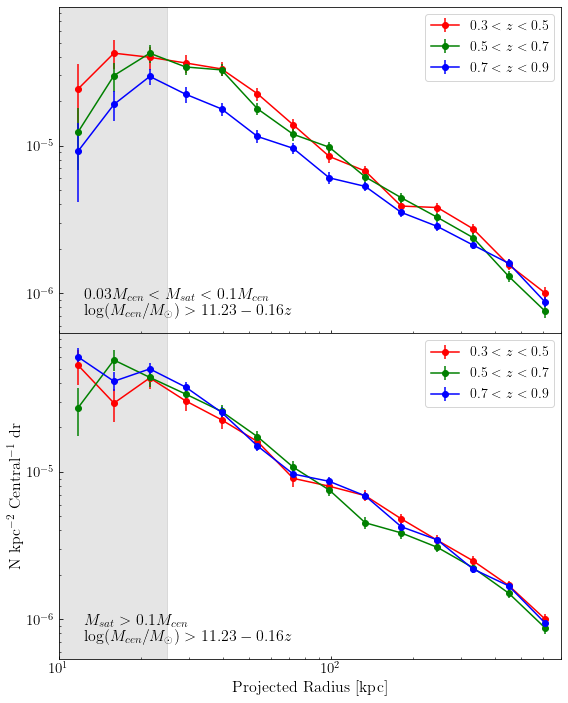

In [68]:
fig, axs = plt.subplots(2, 1, sharex=True,sharey=True, figsize=(9,12))

# panel 1
path = 'CUT_deep_catalogs/split_sat_mass_evo_cen_sat_cut/'  # evolving mass cut
slope = 0
masscut_z0 = 11.15

radial_4 = combine_deep('all','all','0.03','inf',0.4, path)
radial_6 = combine_deep('all','all','0.03','inf',0.6, path)
radial_8 = combine_deep('all','all','0.03','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[0].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[0].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[0].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[0].axhline(2e-5,10,700,linewidth=4, color='r')
axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=14)

# panel 2
path = 'CUT_deep_catalogs/split_sat_mass_evo_cen_sat_cut/'  # evolving mass cut
slope = 0.16
masscut_z0 = 11.23

radial_4 = combine_deep('all','all','0.1','inf',0.4, path)
radial_6 = combine_deep('all','all','0.1','inf',0.6, path)
radial_8 = combine_deep('all','all','0.1','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[1].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[1].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[1].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[1].axhline(2e-5,10,700,linewidth=4, color='r')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[1].legend(fontsize=14)

# annotations
axs[0].annotate('$\log(M_{cen}/M_\odot)>11.23-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{cen}/M_\odot)>11.23-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')

axs[0].annotate('$0.03M_{cen}<M_{sat}<0.1M_{cen}$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$M_{sat}>0.1M_{cen}$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')

# axis labels
axs[1].set_xlabel('Projected Radius [kpc]', fontsize=16)
axs[1].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=16)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,700])
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/radial_evolution_all_cuts_relative.png')

[231, 69, 277, 219, 217]
[250, 93, 328, 224, 293]
[470, 85, 559, 405, 385]
[231, 69, 277, 219, 217]
[250, 93, 327, 224, 293]
[470, 85, 559, 405, 385]


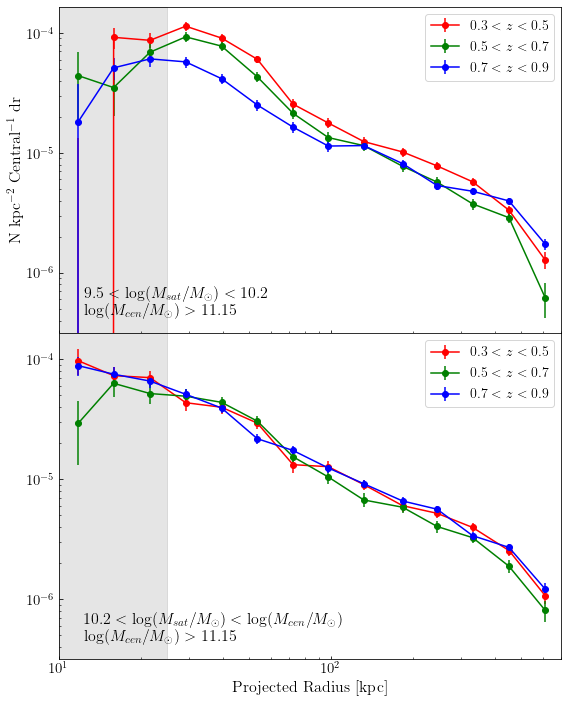

In [69]:
fig, axs = plt.subplots(2, 1, sharex=True,sharey=True, figsize=(9,12))

# panel 1
path = 'CUT_deep_catalogs/split_sat_mass_45_newz/'  # evolving mass cut
slope = 0
masscut_z0 = 11.15

radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[0].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[0].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[0].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[0].axhline(2e-5,10,700,linewidth=4, color='r')
axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=14)

# panel 2
path = 'CUT_deep_catalogs/split_sat_mass_45_newz/'  # evolving mass cut
slope = 0
masscut_z0 = 11.15

radial_4 = combine_deep('all','all','10.2','inf',0.4, path)
radial_6 = combine_deep('all','all','10.2','inf',0.6, path)
radial_8 = combine_deep('all','all','10.2','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

axs[1].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$')
axs[1].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',
             label='$0.5<z<0.7$')
axs[1].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$')
axs[1].axhline(2e-5,10,700,linewidth=4, color='r')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[1].legend(fontsize=14)

# annotations
axs[0].annotate('$\log(M_{cen}/M_\odot)>11.15$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{cen}/M_\odot)>11.15$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')

axs[0].annotate('$9.5<\log(M_{sat}/M_\odot)<10.2$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')

# axis labels
axs[1].set_xlabel('Projected Radius [kpc]', fontsize=16)
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=16)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,700])
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/radial_evolution_low_high_sat_mass.png')

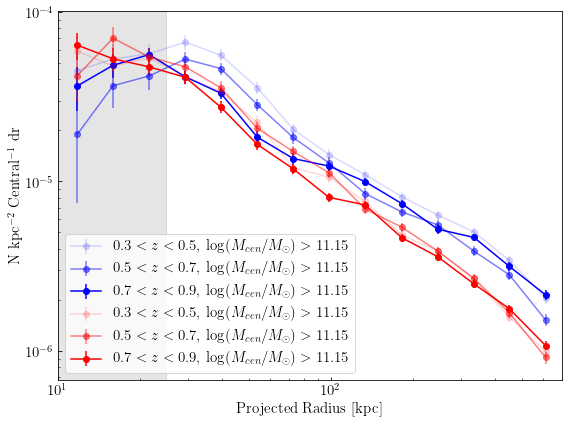

In [18]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

# path = 'CUT_deep_catalogs/total_sample_evo_cen_sat_masscut/'  # evolving mass cut
# slope = 0.16
# masscut_z0 = 11.23
# masscut_type = 'evolving'

path = 'CUT_deep_catalogs/total_sample/' # constant mass cut
slope = 0
masscut_z0 = 11.15
masscut_type = 'constant'
masscut_sat='9.5'
bin_centers = np.load(path+'bin_centers.npy')

# === ssf
radial_4 = combine_deep('all','ssf',masscut_sat,'inf',0.4, path)
radial_6 = combine_deep('all','ssf',masscut_sat,'inf',0.6, path)
radial_8 = combine_deep('all','ssf',masscut_sat,'inf',0.8, path)

plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='ob-',
             label='$0.3<z<0.5$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.4)+'$',alpha=0.15)
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='ob-',
             label='$0.5<z<0.7$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.6)+'$',alpha=0.5)
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',
             label='$0.7<z<0.9$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.8)+'$',alpha=1)


# === sq
radial_4 = combine_deep('all','sq',masscut_sat,'inf',0.4, path)
radial_6 = combine_deep('all','sq',masscut_sat,'inf',0.6, path)
radial_8 = combine_deep('all','sq',masscut_sat,'inf',0.8, path)

plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',
             label='$0.3<z<0.5$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.4)+'$',alpha=0.15)
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='or-',
             label='$0.5<z<0.7$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.6)+'$',alpha=0.5)
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='or-',
             label='$0.7<z<0.9$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.8)+'$',alpha=1)


plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])
plt.tight_layout()
plt.savefig('figures/radial_evolution_ssf_'+masscut_type+'_masscut.png')
plt.show()

## Central Mass Dependence

In [105]:
# no return for central_num
def combine_deep_new(masscut_h_low,z,csfq, ssfq,path='CUT_deep_catalogs/test_host_mass/'):
    affix = '_host_'+str(masscut_h_low)+'_9.5_'+csfq+'_'+ssfq+'_'+str(z)+'.txt'
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    # number of galaxies
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    # split satellite number density and error part
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    
    # number density part
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = [radial_cosmos, radial_sxds, radial_elais,radial_xmmlss, radial_deep]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    # error part
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial,radial_err)


In [106]:
import glob

file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_11.3_0.4.positions.fits')
cat_hm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_hm = vstack([cat_hm,Table.read(file)])
    
file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_11.0_0.4.positions.fits')
cat_mm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_mm = vstack([cat_mm,Table.read(file)])
    
file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_10.8_0.4.positions.fits')
cat_lm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_lm = vstack([cat_lm,Table.read(file)])

/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


low mass 4087 10.8846 0.607
median mass 2737 11.1049 0.733
high mass 575 11.3927 0.868
Q-frac for lm central 0.222
Q-frac for mm central 0.318
Q-frac for hm central 0.395
rs 554.7023057084546 148.102268426946
rs 351.0533086488621 69.5638404693235
rs 301.7150302725492 36.254962371578706


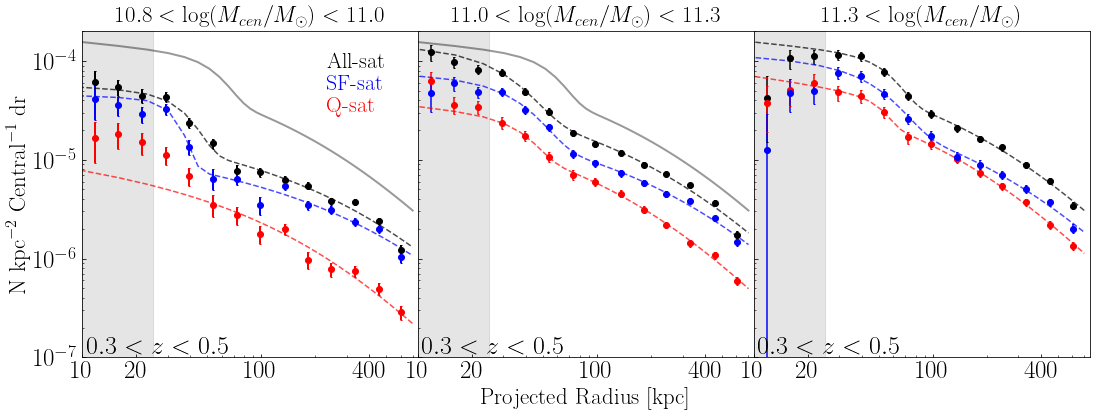

In [107]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=25), plt.rc('ytick', labelsize=25)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
z = 0.4
path = 'CUT_deep_catalogs/split_host_mass_newbkg_newz/'
print('low mass',len(cat_lm),np.median(cat_lm['MASS_MED']),round(len(cat_lm[cat_lm['sfProb']<0.5])/len(cat_lm),3))
print('median mass',len(cat_mm),np.median(cat_mm['MASS_MED']),round(len(cat_mm[cat_mm['sfProb']<0.5])/len(cat_mm),3))
print('high mass',len(cat_hm),np.median(cat_hm['MASS_MED']),round(len(cat_hm[cat_hm['sfProb']<0.5])/len(cat_hm),3))

bin_centers = np.load(path+'bin_centers.npy')
radial_host_lm = combine_deep_new(10.8,z,'all','all',path=path)
radial_host_mm = combine_deep_new(11.0,z,'all','all',path=path)
radial_host_hm = combine_deep_new(11.3,z,'all','all',path=path)

radial_host_lm_sf = combine_deep_new(10.8,z,'all','ssf',path=path)
radial_host_mm_sf = combine_deep_new(11.0,z,'all','ssf',path=path)
radial_host_hm_sf = combine_deep_new(11.3,z,'all','ssf',path=path)

radial_host_lm_q = combine_deep_new(10.8,z,'all','sq',path=path)
radial_host_mm_q = combine_deep_new(11.0,z,'all','sq',path=path)
radial_host_hm_q = combine_deep_new(11.3,z,'all','sq',path=path)

radial_sim_lm = np.load('radial_tot_lm.npy')
radial_sim_mm = np.load('radial_tot_mm.npy')
radial_sim_hm = np.load('radial_tot_hm.npy')


# calculate red fraction
red_frac_lm = radial_host_lm_q[0]/radial_host_lm[0]
red_frac_mm = radial_host_mm_q[0]/radial_host_mm[0]
red_frac_hm = radial_host_hm_q[0]/radial_host_hm[0]
print('Q-frac for lm central',round(np.average(red_frac_lm[2:],weights=areas[2:]),3))
print('Q-frac for mm central',round(np.average(red_frac_mm[2:],weights=areas[2:]),3))
print('Q-frac for hm central',round(np.average(red_frac_hm[2:],weights=areas[2:]),3))

# plot the distributions
axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=1,linewidth=2)
# axs[0].plot(bin_centers,radial_sim_lm,'--og',linewidth=2)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=1)
# axs[1].plot(bin_centers,radial_sim_mm,'--og',linewidth=2)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=1)
# axs[2].plot(bin_centers,radial_sim_hm,'--og',linewidth=2)

# fitting
fit_x = np.linspace(2,700,num=100)
start = 4

popt_lm,pcov_lm,chi2 = fit_nfw_sersic_fix_n(bin_centers,radial_host_lm[0],radial_host_lm[1], start=4)
popt_mm,pcov_mm,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm[0],radial_host_mm[1], start=4)
popt_hm,pcov_hm,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm[0],radial_host_hm[1], start=4)

popt_lm_sf,pcov_lm_sf,chi2 = fit_nfw_sersic(bin_centers,radial_host_lm_sf[0],radial_host_lm_sf[1], start=4)
popt_mm_sf,pcov_mm_sf,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm_sf[0],radial_host_mm_sf[1], start=4)
popt_hm_sf,pcov_hm_sf,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm_sf[0],radial_host_hm_sf[1], start=4)

popt_lm_q,pcov_lm_q,chi2 = fit_nfw_sersic(bin_centers,radial_host_lm_q[0],radial_host_lm_q[1], start=4)
popt_mm_q,pcov_mm_q,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm_q[0],radial_host_mm_q[1], start=4)
popt_hm_q,pcov_hm_q,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm_q[0],radial_host_hm_q[1], start=4)

perr_lm = np.sqrt(np.diag(pcov_lm))
perr_mm = np.sqrt(np.diag(pcov_mm))
perr_hm = np.sqrt(np.diag(pcov_hm))

print('rs',popt_lm[0],perr_lm[0])
print('rs',popt_mm[0],perr_mm[0])
print('rs',popt_hm[0],perr_hm[0])

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]),'--k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'--k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm[0],popt_mm[1],popt_mm[2],popt_mm[3],popt_mm[4]),'--k',alpha=0.7)
axs[0].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'k',alpha=0.4,linewidth=2)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'k',alpha=0.4,linewidth=2)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm_sf[0],popt_lm_sf[1],popt_lm_sf[2],popt_lm_sf[3],popt_lm_sf[4]),'--b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm_sf[0],popt_mm_sf[1],popt_mm_sf[2],popt_mm_sf[3],popt_mm_sf[4]),'--b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm_sf[0],popt_hm_sf[1],popt_hm_sf[2],popt_hm_sf[3],popt_hm_sf[4]),'--b',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm_q[0],popt_lm_q[1],popt_lm_q[2],popt_lm_q[3],popt_lm_q[4]),'--r',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm_q[0],popt_mm_q[1],popt_mm_q[2],popt_mm_q[3],popt_mm_q[4]),'--r',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm_q[0],popt_hm_q[1],popt_hm_q[2],popt_hm_q[3],popt_hm_q[4]),'--r',alpha=0.7)

axs[0].set_title(r'$10.8<\log(M_{cen}/M_\odot)<11.0$',fontsize=23)
axs[1].set_title(r'$11.0<\log(M_{cen}/M_\odot)<11.3$',fontsize=23)
axs[2].set_title(r'$11.3<\log(M_{cen}/M_\odot)$',fontsize=23)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

axs[0].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[1].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[2].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=23)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0) 
plt.savefig('figures/split_host_mass_sfProb'+str(z)+'.png')
plt.show()

No handles with labels found to put in legend.


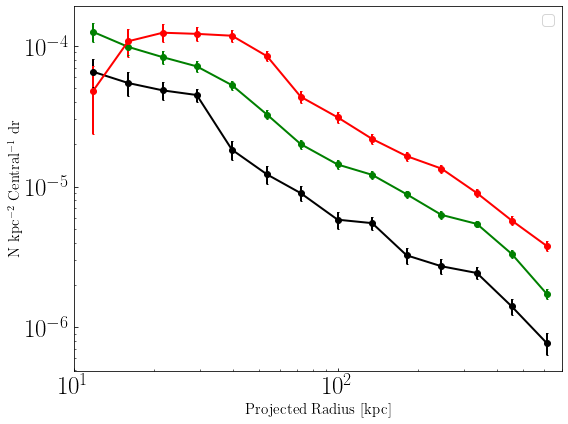

In [85]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))


plt.errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='-ok',capsize=1,linewidth=2)
plt.errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='-og',capsize=1,linewidth=2)
plt.errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='-or',capsize=1,linewidth=2)

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


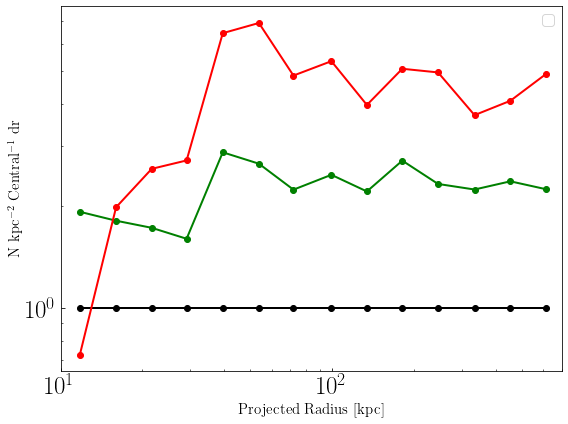

In [83]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

plt.plot(bin_centers,radial_host_lm[0]/radial_host_lm[0],'-ok',linewidth=2)
plt.plot(bin_centers,radial_host_mm[0]/radial_host_lm[0],'-og',linewidth=2)
plt.plot(bin_centers,radial_host_hm[0]/radial_host_lm[0],'-or',linewidth=2)

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])
plt.tight_layout()
plt.show()

low mass 4087 0.607
median mass 2737 0.733
high mass 575 0.868
rs 316.5033042780071 63.51911524832137
rs 281.1804189656965 41.802055200308494
rs 214.9372611202863 34.210575300464036


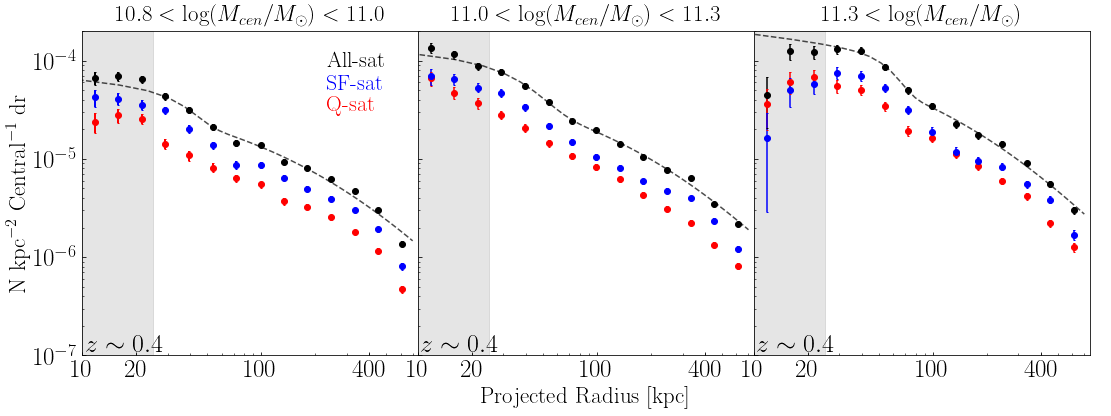

In [14]:
###########
# without isolation criteria

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=25), plt.rc('ytick', labelsize=25)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
z = 0.4

print('low mass',len(cat_lm),round(len(cat_lm[cat_lm['sfProb']<0.5])/len(cat_lm),3))
print('median mass',len(cat_mm),round(len(cat_mm[cat_mm['sfProb']<0.5])/len(cat_mm),3))
print('high mass',len(cat_hm),round(len(cat_hm[cat_hm['sfProb']<0.5])/len(cat_hm),3))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
path = 'CUT_deep_catalogs/split_host_mass_noiso/'
radial_host_lm = combine_deep_new(10.8,z,'all','all',path=path)
radial_host_mm = combine_deep_new(11.0,z,'all','all',path=path)
radial_host_hm = combine_deep_new(11.3,z,'all','all',path=path)

radial_host_lm_sf = combine_deep_new(10.8,z,'all','ssf',path=path)
radial_host_mm_sf = combine_deep_new(11.0,z,'all','ssf',path=path)
radial_host_hm_sf = combine_deep_new(11.3,z,'all','ssf',path=path)

radial_host_lm_q = combine_deep_new(10.8,z,'all','sq',path=path)
radial_host_mm_q = combine_deep_new(11.0,z,'all','sq',path=path)
radial_host_hm_q = combine_deep_new(11.3,z,'all','sq',path=path)

radial_sim_lm = np.load('radial_tot_lm.npy')
radial_sim_mm = np.load('radial_tot_mm.npy')
radial_sim_hm = np.load('radial_tot_hm.npy')

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=1,linewidth=2)
# axs[0].plot(bin_centers,radial_sim_lm,'--og',linewidth=2)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=1)
# axs[1].plot(bin_centers,radial_sim_mm,'--og',linewidth=2)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=1)
# axs[2].plot(bin_centers,radial_sim_hm,'--og',linewidth=2)

# fitting
fit_x = np.linspace(2,700,num=100)
start = 4

popt_lm,pcov_lm,chi2 = fit_nfw_sersic(bin_centers,radial_host_lm[0],radial_host_lm[1], start=4)
popt_mm,pcov_mm,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm[0],radial_host_mm[1], start=4)
popt_hm,pcov_hm,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm[0],radial_host_hm[1], start=4)

perr_lm = np.sqrt(np.diag(pcov_lm))
perr_mm = np.sqrt(np.diag(pcov_mm))
perr_hm = np.sqrt(np.diag(pcov_hm))

print('rs',popt_lm[0],perr_lm[0])
print('rs',popt_mm[0],perr_mm[0])
print('rs',popt_hm[0],perr_hm[0])

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]),'--k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm[0],popt_mm[1],popt_mm[2],popt_mm[3],popt_mm[4]),'--k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'--k',alpha=0.7)

axs[0].set_title(r'$10.8<\log(M_{cen}/M_\odot)<11.0$',fontsize=23)
axs[1].set_title(r'$11.0<\log(M_{cen}/M_\odot)<11.3$',fontsize=23)
axs[2].set_title(r'$11.3<\log(M_{cen}/M_\odot)$',fontsize=23)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

axs[0].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[1].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[2].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=23)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/split_host_mass_sfProb'+str(z)+'_noiso.png')
plt.show()

###########
# without isolation criteria

### split both central mass and central sfq

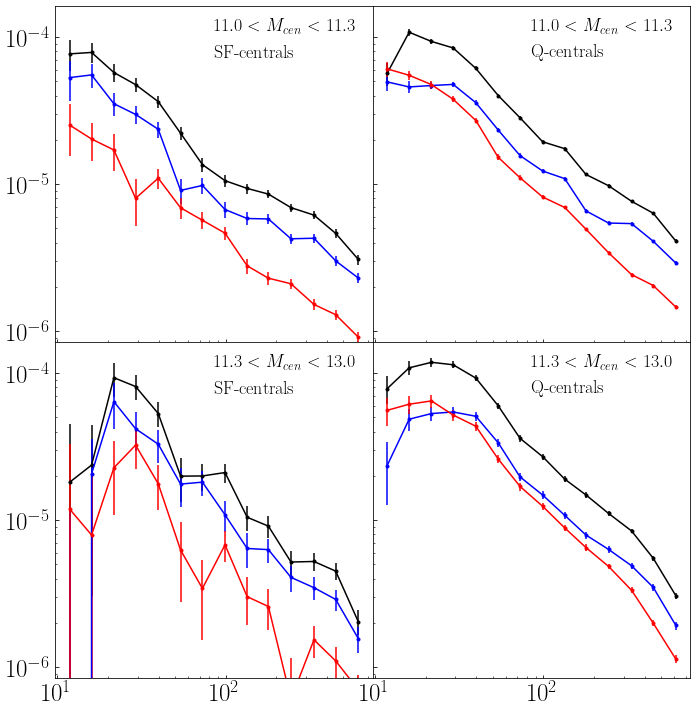

In [58]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(10, 10),gridspec_kw={'height_ratios':[1,1]})

path = 'CUT_deep_catalogs/split_host_color_mass/'
z=0.6

for i, mass_host_low in enumerate([[11.0,11.3],[11.3,13.0]]):
    for j, csfq in enumerate(['csf','cq']):
        radial_all = combine_deep_new(mass_host_low[0],z,csfq,'all',path=path)
        radial_ssf = combine_deep_new(mass_host_low[0],z,csfq,'ssf',path=path)
        radial_sq = combine_deep_new(mass_host_low[0],z,csfq,'sq',path=path)
    
        axs[i][j].errorbar(bin_centers,radial_all[0],yerr=radial_all[1],fmt='.-k')
        axs[i][j].errorbar(bin_centers,radial_ssf[0],yerr=radial_ssf[1],fmt='.-b')
        axs[i][j].errorbar(bin_centers,radial_sq[0],yerr=radial_sq[1],fmt='.-r')
        
        axs[i][j].annotate(r'$'+str(mass_host_low[0])+'<M_{cen}<'+str(mass_host_low[1])+'$',
                           xy=(0.5,0.92),xycoords='axes fraction',fontsize=18)
        if csfq == 'csf':
            print_csfq = 'SF-centrals'
        else:
            print_csfq = 'Q-centrals'
            
        axs[i][j].annotate(print_csfq,xy=(0.5,0.85),xycoords='axes fraction',color='k',fontsize=18)
        
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show()